# Исследование клиентов банка с целью минимизации оттока. 

**Описание данных**

Датасет содержит данные о клиентах банка «Метанпром» в csv-файле. Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск. Цель исследования - составление портретов клиентов, которые склонны прекращать сотрудничество с банком.

Набор данных включает следующие поля:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

## Декомпозиция задачи

### Загрузка и ознакомление

1. Импортируем необходимые библиотеки и общие настройки.
2. Откроем файл с данными.
3. Исследуем пропущенные значения, соответствие типов.
4. Изучим числовое описание признаков.
5. Проверим наличие дубликатов.
6. Приведем наименования колонок к змеиному регистру.
7. При необходимости переименуем колонки, удалим дубликаты, приведем данные к нужным типам.
9. Исследуем пропущенные значения и заполним в случае необходимости.
10. Зафиксируем найденные особенности и созданные изменения в выводе.

### Исследовательский анализ данных

1. Исследуем средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался;
2. Построим столбчатые гистограммы признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);
3. Исследуем распределение признаков на нормальность. 
4. Построим матрицу корреляций и отобразим её.
5. Сделаем выводы

### Проверка гипотез.

1. Проверим гипотезы о различиях дохода, баллах кредитного скоринга, возраста, количества объектов, количества продуктов, баланса ушедших и оставшихся клиентов с помощью непараметрического теста Манна-Уитни (поскольку часть распределений отличается от нормальных).

2. Сформулируем выводы.

### Построение модели бинарной классификации по признаку оттока.

1. Преобразуем категориальные признаки в числовые.
2. Разобьем данные на обучающую и валидационную выборку
3. Стандартизируем данные
4. Обучим модель на train-выборке 4 способами:
  - логистической регрессией
  - деревом принятия решений
  - случайным лесом 
  - градиентным бустингом.
5. Сравним метрики моделей на валидационной выборке и выберем лучшую. 
6. Выведем и отсортируем по важности признаки оттока клиентов, полученные лучшей моделью. 
7. Сделаем выводы.

### Выводы и презентация проекта

1. Сформулируем выводы по проекту в соответствии с целью исследования: 
    - опишем влияние представленных признаков на отток
    - обозначим направления возможной работы с целью минимизации оттока.   
2. Построим дашборд, дадим описание его работы. 
3. Создадим презентацию проекта.

## Загрузка и ознакомление

### Импорт библиотек и данных.

Загрузим необходимые библиотеки и настроим параметры отображения данных.

In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns


from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

pd.options.display.float_format ='{:,.2f}'.format # ограничим вывод дробной части до сотых

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # скроем предупреждения о будущих изменениях

matplotlib.style.use('seaborn-dark') # настроим стиль отображения графиков
sns.set_palette('muted') # зададим палитру графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6  # зададим размеры всех графиков
%config InlineBackend.figure_format = 'retina' # добавим четкости графикам 

Откроем файл с данными, запишем его в переменную `df`

In [2]:
df = pd.read_csv('/datasets/bank_dataset.csv')
# убедимся, что загрузка прошла успешно
df.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,"101,348.88",1
1,15690047,608,Рыбинск,Ж,41,1,"83,807.86",1,0,1,"112,542.58",0
2,15662040,502,Ярославль,Ж,42,8,"159,660.80",3,1,0,"113,931.57",1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,"93,826.63",0
4,15780624,850,Рыбинск,Ж,43,2,"125,510.82",1,1,1,"79,084.10",0


### Ознакомление с данными и их преобразование

Напишем функцию для ознакомления с данными сета. 

In [3]:
def inspect(data):
    '''Функция для первичного ознакомления с данными
    
    Принимает на вход датасет, 
    приводит наименования колонок к змеиному регистру,
    выводит общую информацию о пропусках, типах данных и параметрах сета,
    наличии дубликатов,
    числовых характеристиках количественных и категориальных данных, 
    числе уникальных значений признаков с идентификаторами,
    возвращает 5 случайных строк.'''
    
    data.columns = [x.lower() for x in data.columns.values]
    data.info() 
    print(90*'-')
    print ('Количество дубликатов -', data.duplicated().sum())
    print(90*'-')
    display(data.describe())
    print(90*'-')
    numeric_columns=data.describe().columns
    for column_name in data.columns:
        if column_name not in numeric_columns:
            if 'id' not in column_name:
                display(data[column_name].value_counts())
                print(90*'-')
        elif 'id' in column_name:
            print ('Уникальных значений', column_name)
            display(data[column_name].nunique())
            print(90*'-')
    return data.sample(5)

Применим фукнцию `inspect`

In [4]:
inspect(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   city              10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   objects           10000 non-null  int64  
 6   balance           6383 non-null   float64
 7   products          10000 non-null  int64  
 8   creditcard        10000 non-null  int64  
 9   loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB
------------------------------------------------------------------------------------------
Количество дубликатов - 0
-----------------------------------------------------

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
count,"10,000.00","10,000.00","10,000.00","10,000.00","6,383.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00"
mean,"15,733,676.57",650.53,38.92,5.01,"119,827.49",1.53,0.71,0.52,"100,090.24",0.20
std,"71,936.19",96.65,10.49,2.89,"30,095.06",0.58,0.46,0.50,"57,510.49",0.40
min,"15,608,437.00",350.00,18.00,0.00,"3,768.69",1.00,0.00,0.00,11.58,0.00
25%,"15,671,264.25",584.00,32.00,3.00,"100,181.98",1.00,0.00,0.00,"51,002.11",0.00
50%,"15,733,474.00",652.00,37.00,5.00,"119,839.69",1.00,1.00,1.00,"100,193.91",0.00
75%,"15,795,969.75",718.00,44.00,7.00,"139,512.29",2.00,1.00,1.00,"149,388.25",0.00
max,"15,858,426.00",850.00,92.00,10.00,"250,898.09",4.00,1.00,1.00,"199,992.48",1.00


------------------------------------------------------------------------------------------
Уникальных значений userid


10000

------------------------------------------------------------------------------------------


Ярославль         5014
Ростов Великий    2509
Рыбинск           2477
Name: city, dtype: int64

------------------------------------------------------------------------------------------


М    5457
Ж    4543
Name: gender, dtype: int64

------------------------------------------------------------------------------------------


,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
9066,15768245,662,Ростов Великий,М,30,5,"115,286.68",2,1,1,"149,587.92",0
3323,15783366,487,Рыбинск,Ж,31,1,NaN,2,1,0,"158,750.13",0
5356,15698172,839,Ростов Великий,М,47,2,"136,911.07",1,1,1,"168,184.62",1
8378,15744055,614,Ростов Великий,Ж,37,6,"96,340.81",2,1,1,"139,377.24",1
7621,15647699,661,Ярославль,М,39,5,NaN,2,0,0,"181,461.46",0


Переименуем некоторые признаки для единообразия и удобства дальнейшей обработки.

In [5]:
df.rename(columns={'userid': 'user_id',
                   'creditcard': 'credit_card'}, inplace=True)
df.columns # удостоверимся, что переименовения прошло успешно

Index(['user_id', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'credit_card', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')

Преобразуем признак пола в числовые значения, где 1 - мужской, 0 - женский.

In [6]:
df['gender'] = df['gender'].map({'М': 1, 'Ж': 0})
df['gender'].value_counts() # убедимся в успешности преобразования

1    5457
0    4543
Name: gender, dtype: int64

Изучим **пропущенные значения в столбце `balance`**. Попытаемся найти значимые корреляции с остальными данными для заполнения пропусков.

In [7]:
df.corrwith(df['balance'])

user_id            -0.01
score              -0.00
gender              0.03
age                -0.01
objects             0.01
balance             1.00
products           -0.00
credit_card         0.01
loyalty            -0.02
estimated_salary   -0.00
churn               0.02
dtype: float64

Значимых корреляций с другими признаками не обнаруживается. Следовательно, заполнить пропущенные данные, исходя из значений других признаков, не удастся. 

Поскольку основная цель исследования - признак оттока, изучим значения оттока для двух групп: клиентов с пропуском в уровне дохода и заполненным значением. Посчитаем соотношение оттока для каждого подсета.

In [8]:
# создадим два подфрейма с клиентами, у которых не заполнен баланс и с заполненным
df_isna = df[df['balance'].isna()].reset_index()
df_not_isna = df.dropna().reset_index()

print ('Среднее значение оттока группы клиентов с пропусками в балансе', df_isna['churn'].mean())
print ('Среднее значение оттока группы клиентов с заполненным балансом', df_not_isna['churn'].mean())

Среднее значение оттока группы клиентов с пропусками в балансе 0.13823610727121924
Среднее значение оттока группы клиентов с заполненным балансом 0.2407958640137866


Итак, клиенты с незаполненным уровнем дохода уходят даже реже, чем с заполненным. Следовательно, уход клиентов не связан с отстутствием средств на депозитных счетах. 

Проанализируем соотношения остальных признаков по критерию оттока отдельно для клиентов с заполненным балансом и с пропуском значения. 

In [9]:
# сгруппируем каждый подфрейм по признаку оттока, получим средние показатели признаков
df_isna_grouped = df_isna.groupby('churn', as_index=False).mean().T
df_not_isna_grouped = df_not_isna.groupby('churn', as_index=False).mean().T

# сформируем столбец с соотношением признаков в каждом подфрейме
df_isna_grouped['relation'] = df_isna_grouped[0] / df_isna_grouped[1]
df_not_isna_grouped['relation'] = df_not_isna_grouped[0] / df_not_isna_grouped[1]

# выведем разницу соотношений 
display(df_isna_grouped['relation'] - df_not_isna_grouped['relation'])

churn               0.00
index               0.06
user_id            -0.00
score              -0.00
gender              0.05
age                -0.00
objects             0.06
balance              NaN
products            0.29
credit_card         0.02
loyalty            -0.05
estimated_salary   -0.02
Name: relation, dtype: float64

Заметно, что у группы клиентов с пустым балансом существенно отличается соотношение числа используемых продуктов в группе оттока и группе оставшихся клиентов. В группе с пустым балансом у оставшихся с банком клиентов большее число используемых продуктов. 

Проанализиуем особенности числа продуктов для группы с заполненным балансом и пустым

In [10]:
print ('Число продуктов в группе c заполненным балансом:')
display(df_not_isna['products'].value_counts())

print ('Число продуктов в группе с пропуском баланса:')
df_isna['products'].value_counts()

Число продуктов в группе c заполненным балансом:


1    4179
2    1990
3     168
4      46
Name: products, dtype: int64

Число продуктов в группе с пропуском баланса:


2    2600
1     905
3      98
4      14
Name: products, dtype: int64

В группе с заполненным балансом соотношение клиентов с одним продуктом и с двумя - примерно 2 : 1.

В группе с незаполненным балансом соотношение клиентов с одним продуктом и с двумя - примерно 1 : 3.

Т.е. в группе с незаполненным балансом в целом существенно больше клиентов, использующих 2 продукта. Возможно, имеено этот продукт и дает клиентам возможность пользоваться услугами банка без дебетового счета. Следовательно, найденную особенность следует считать нормальной.

Учитывая, что 
- остальные признаки заполнены во всех строках, 
- пропусков довольно много,
- отсутствие сведений о балансе не увеличивает риск оттока,
- соотношение средних показателей признаков в группе с балансом и без по оттоку примерно одинаково,
- строки с пропусками баланса могут содержать существенную для исследования информацию по другим признакам

оставим пропуски в столбце баланса без изменений. 

Будем фильтровать сет от данных с пропусками по мере необходимости. 

### Вывод

* В представленном сете 10 000 записей по 12 признакам.
* Наименования признаков приведены к "змеиному" регистру и переименованы для единообразия и удобства обращения.
* Дубликатов нет.
* Пользователи уникальны по id.
* Типы данных соответствуют дальнейшим целям исследования.
* Признак пола преобразован в числовые данные (1-мужской, 0-женский).
* Присутствуют пропущенные значения в столбце баланса, что является возможным и допустимым, если клиент не пользуется дебетовыми продуктами банка. По представленным признакам адекватно заполнить пропущенные значения не представляется возможным. Вероятность оттока у клиентов с пропуском баланса даже ниже, чем у остальных. Соотношение средних показателей признаков в группе с балансом и без по оттоку примерно одинаково. Возможна дальнейшая фильтрация пропусков по мере необходимости. 
* Особенности признаков: 
    - `score` - баллы кредитного скоринга от 350 до 850, без явных выбросов (медиана и среднее примерно на одном уровне - 650)
    - `city` - представлены клиенты 3-х городов: Ярославля (5014 клиентов) - более 50% сета, Ростова Великого (2509) - около 25% и Рыбинска (2477) - около 25%.
    - `gender` - клиенты мужского пола встречаются в данных немного чаще, чем женского (55% против 45%)
    - `age` - возраст клиентов от 18 до 92 лет со средним значением 38.92 и медианным 37 лет
    - `objects` - количество объектов в собственности от 1 до 10 (среднее и медиана - 5)
    - `balance` - баланс счета от 3 768.69 до 250 898.09, без явных выбросов (среднее и медиана около 120 000)
    - `products` - количество используемых продуктов банка от 1 до 4, присутствуют выбивающиеся значения - среднее (1,53) больше медианы (1)
    - `credit_card` - кредитная карта есть у 71% клиентов
    - `loyalty` - активными клиентами признаны около половины (52%)
    - `estimated_salary` - предполагаемый уровень заработной платы от 11.58 до 199 992.48 со средним и медианой около 100 000
    - `churn` - отток клиентов по текущим данным составил 20% 

## Исследовательский анализ данных

### Средние значения признаков групп оттока и оставшихся клиентов.

Изучим средние значения признаков в двух группах: тех, кто ушел в отток и тех, кто остался.

,score,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary
churn,,,,,,,,,
0,651.85,0.57,37.41,5.03,"119,535.86",1.54,0.71,0.55,"99,738.39"
1,645.35,0.44,44.84,4.93,"120,746.97",1.48,0.70,0.36,"101,465.68"


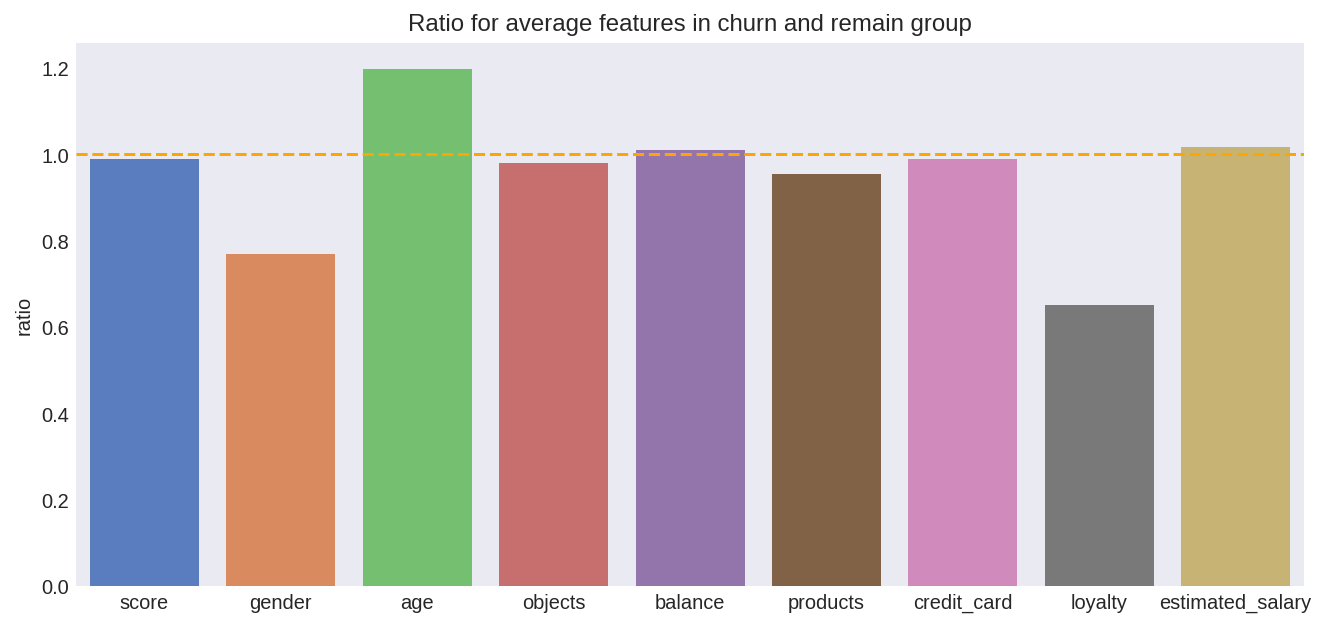

In [11]:
df_grouped = df.groupby('churn').mean().T
df_grouped.drop('user_id', axis=0, inplace=True)
display(df_grouped.T)
df_grouped['ratio'] = df_grouped[1]/df_grouped[0]
plt.figure(figsize=(11, 5))
g = sns.barplot(x=df_grouped.index, y='ratio', data=df_grouped).set_title(
    'Ratio for average features in churn and remain group')
plt.axhline(y=1, color='orange', linestyle='--');

В среднем, чаще попадают в отток клиенты женского пола, старше по возрасту и менее активные. 

Небольшие отличия среднего существуют по числу используемых продуктов (у оставшихся клиентов среднее число продуктов несколько выше), однако здесь могут оказывать влияние клиенты с незаполненным балансом: их число продуктов выше, а отток ниже. 

Группы не демонстрируют существенной разницы средних показателей оттока по наличию кредитных продуктов, количеству объектов собственности, скоринговому баллу, балансу или предполагаемой зарплате.   

### Гистрограммы признаков ушедших в отток и оставшихся клиентов

Рассмотрим распределение числовых и категориальных признаков клиентов двух групп: ушедших и оставшихся.

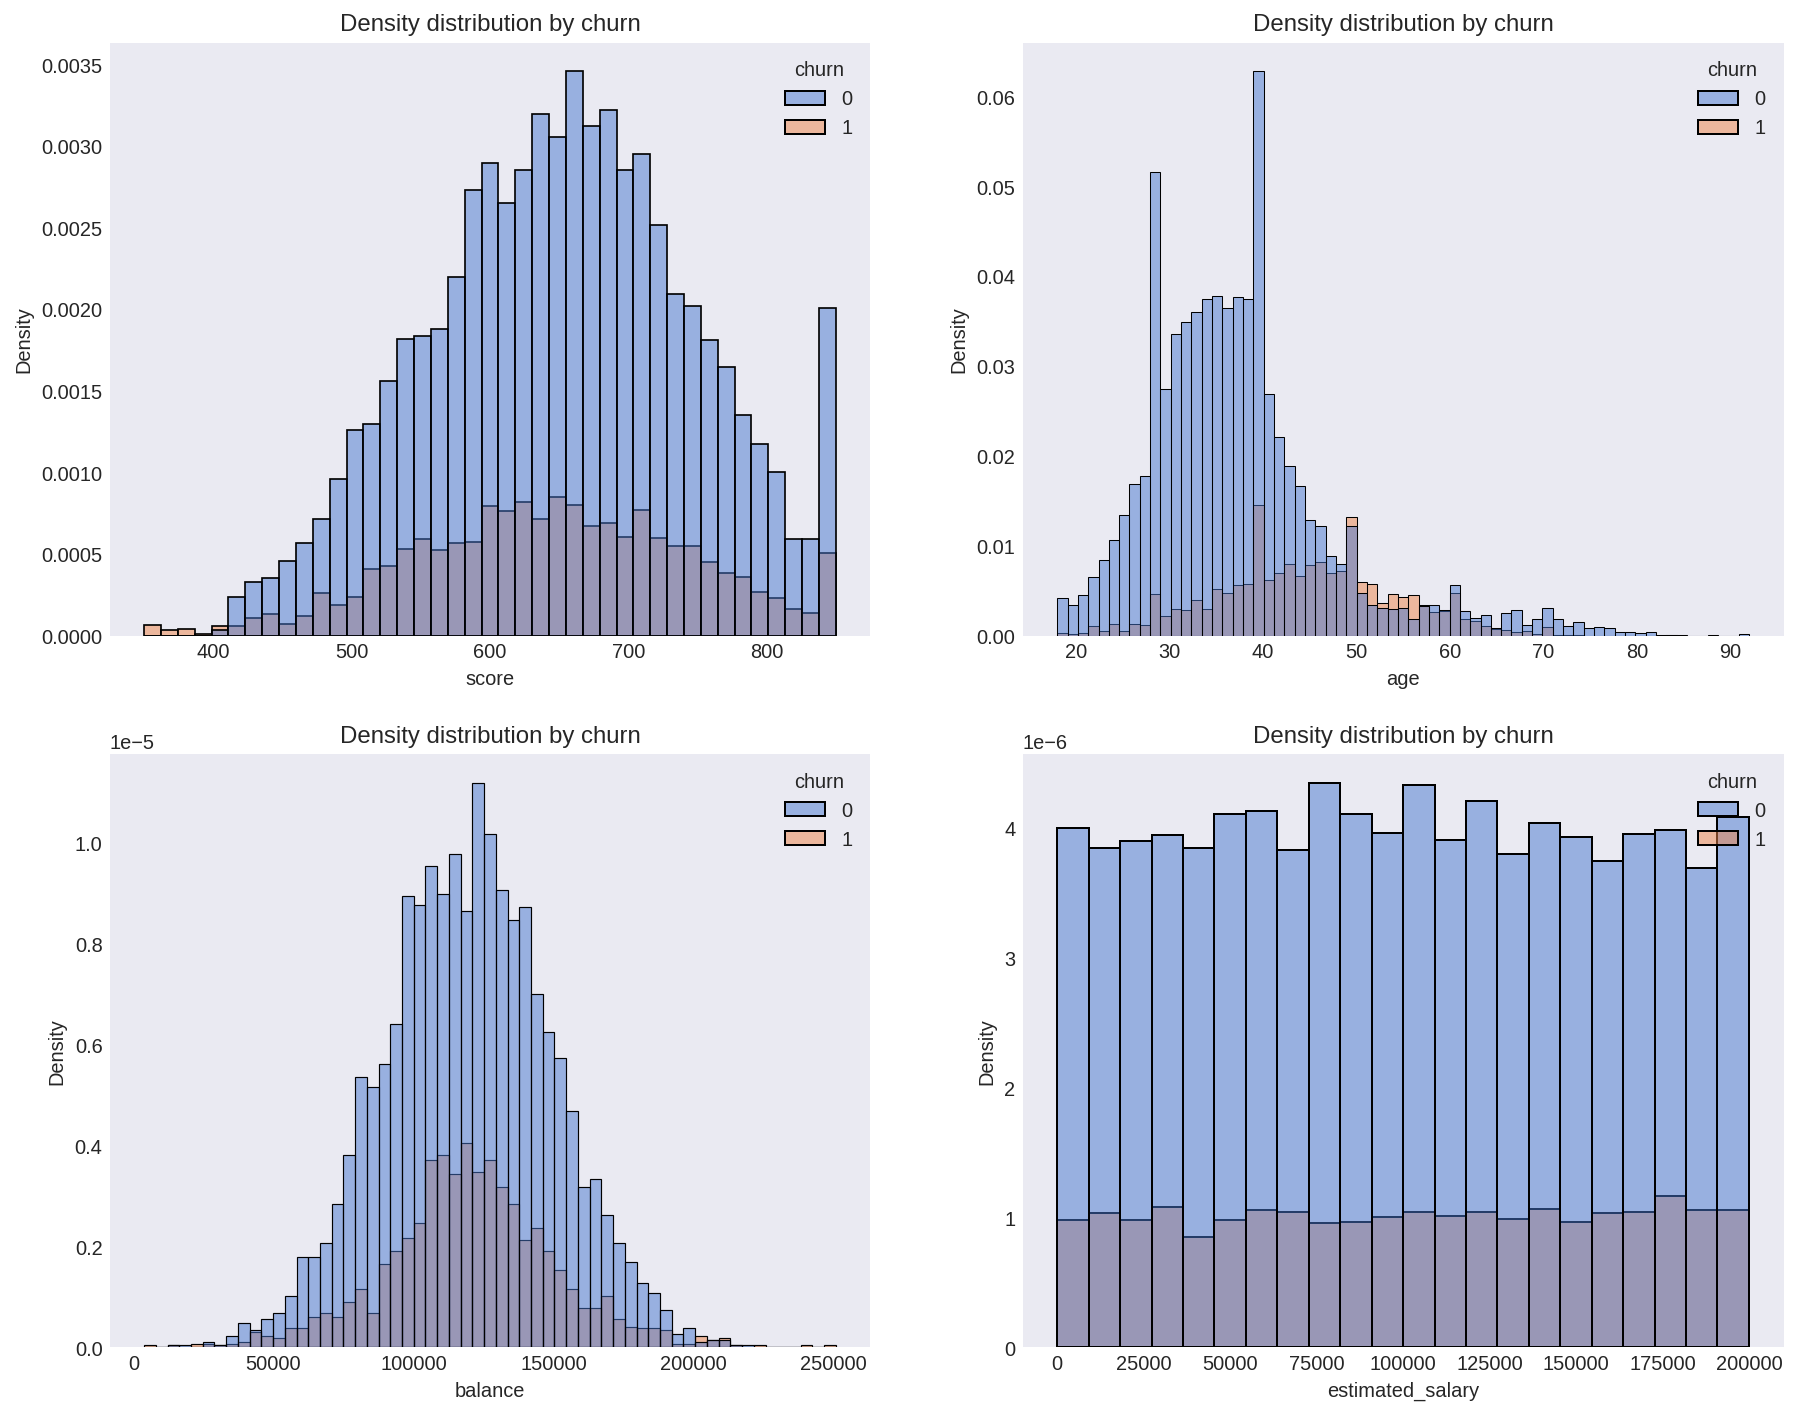

In [12]:
df_columns_num = ['score', 'age', 'balance', 'estimated_salary']
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
ax = ax.ravel()
for i in range(len(df_columns_num)):
    sns.histplot(ax=ax[i], x=df_columns_num[i], hue='churn', 
                 data=df, stat='density').set_title('Density distribution by churn')

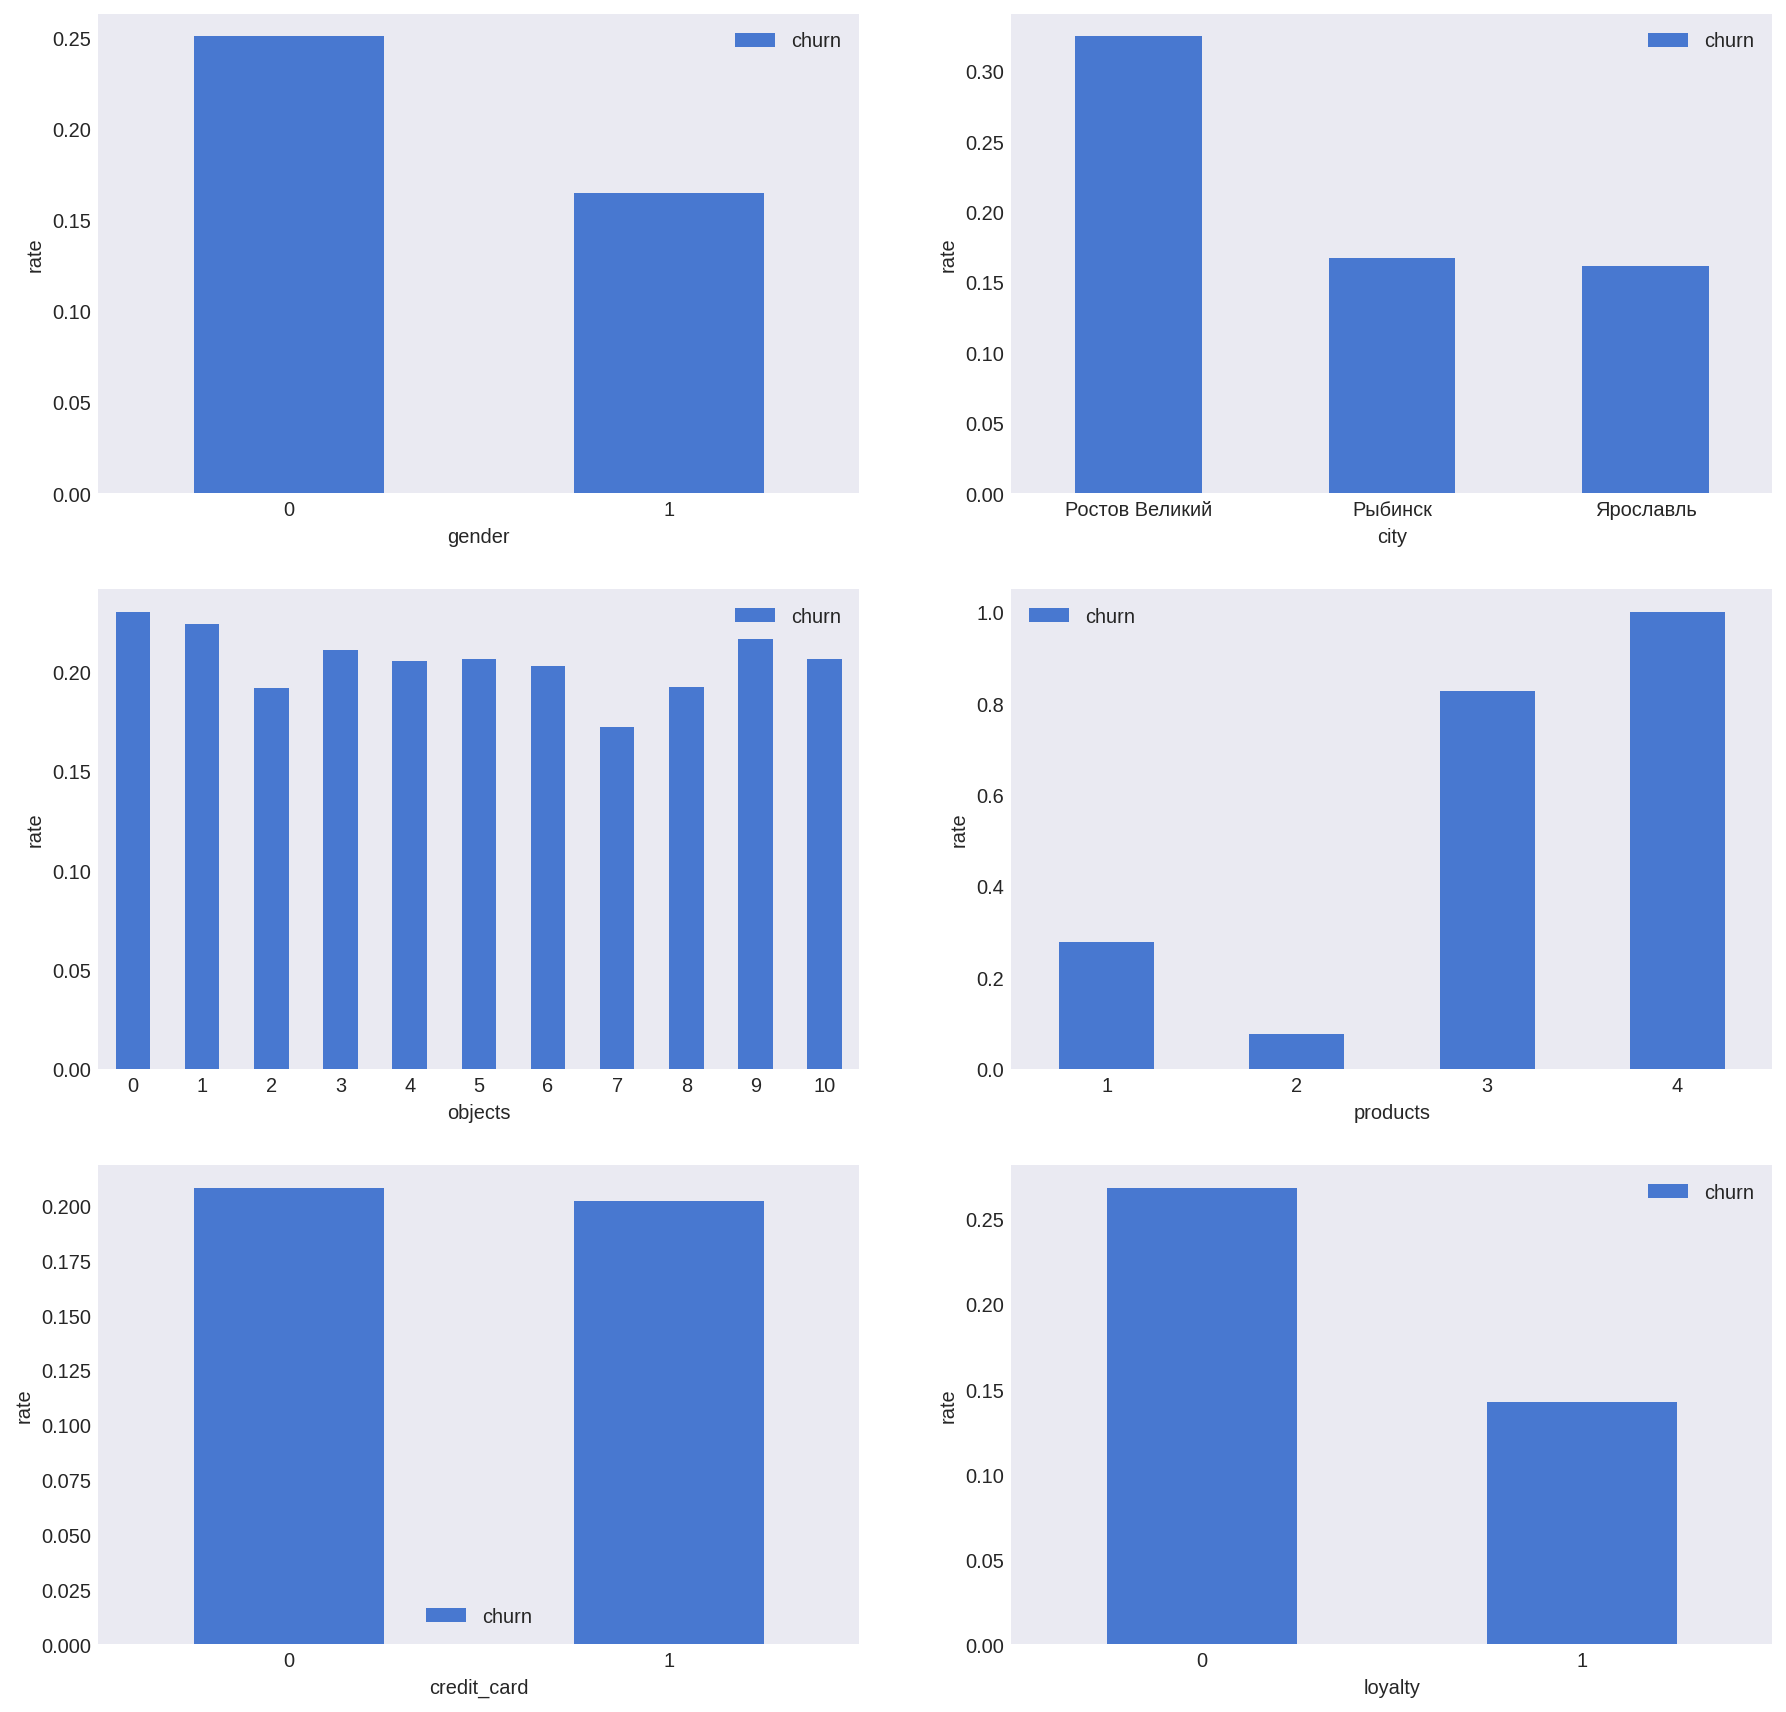

In [13]:
df_columns_cat = ['gender', 'city', 'objects', 'products', 'credit_card', 'loyalty']
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
ax = ax.ravel()
for i,col in enumerate(df_columns_cat):
    df.pivot_table(index=col, values='churn').plot(kind='bar', ax=ax[i], ylabel='rate')
    xlabels = df.pivot_table(index=col, values='churn').index
    ax[i].set_xticklabels(xlabels, rotation=0, ha='center')

По графикам заметно, что в отток попадают 
- все клиенты с низкими скоринговыми баллами до 400 (вероятно, те клиенты, которые пришли в банк за кредитом и не получили одобрение на займ)
- треть всех жителей Ростова Великого (вероятность оттока в два раза выше, чем для других двух городов)
- больше женщин, чем мужчин (25% к 16%)
- чаще клиенты в возрасте 45-65 лет. В интервале 50-57 в отток попадает больше, чем остается. Может быть связано с уходом на пенсию и окончанием зарплатных проектов в банке или погашением кредитов.
- все клиенты, использующие 4 продукта банка, и бОльшая часть (около 80%) тех, кто использует 3. Однако число таких клиентов крайне мало, поэтому на средних баллах тенденция не отражается. 
- чаще неактивные клиенты, чем активные (27% к 14%)

Количество объектов в собственности, баланс, наличие кредитной карты и уровень зарплаты существенно не влияют на факт оттока в представленных данных. 

Всплески оттока для клиентов с очень малым и очень большим балансом могут быть случайными, поскольку число таких клиентов мало. 

Найденные тенденции сохраняются в разрезе других признаков. Так, например, отток клиентов из разных городов не зависит от их пола. 

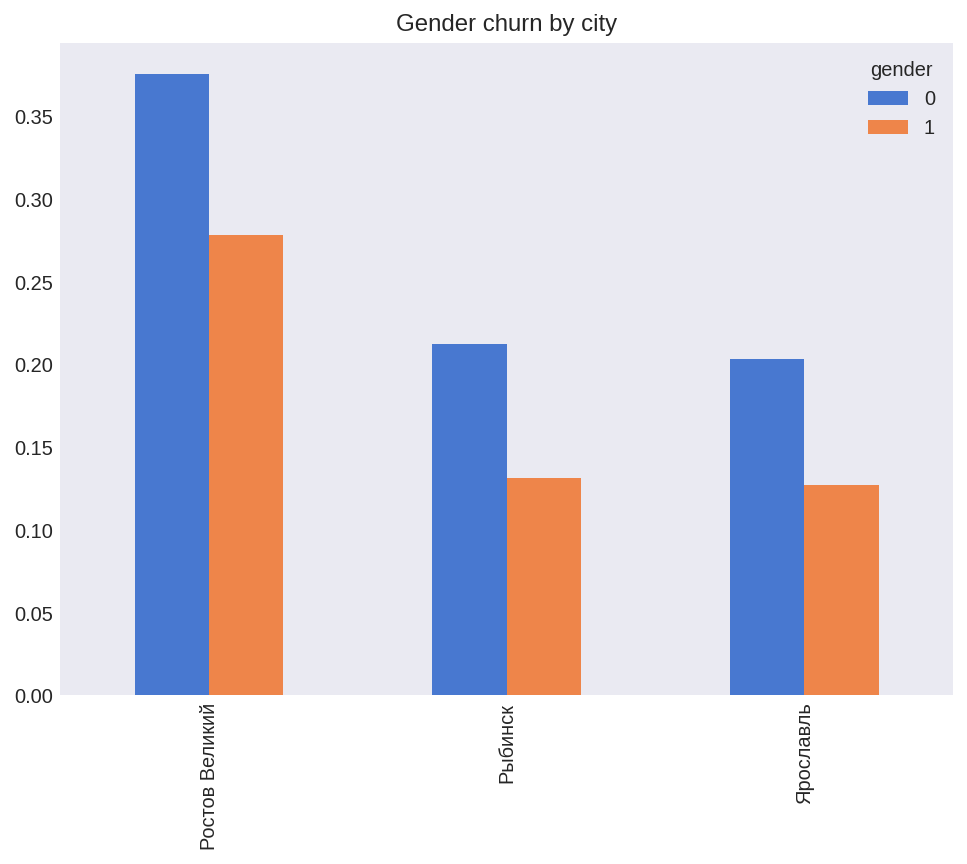

In [14]:
df.pivot_table(index='city', columns='gender', values='churn').plot(kind='bar',
    title='Gender churn by city', xlabel='');

Тенденция всех клиентов уходить из банка при использовании 4 продуктов не зависит от их активности. 

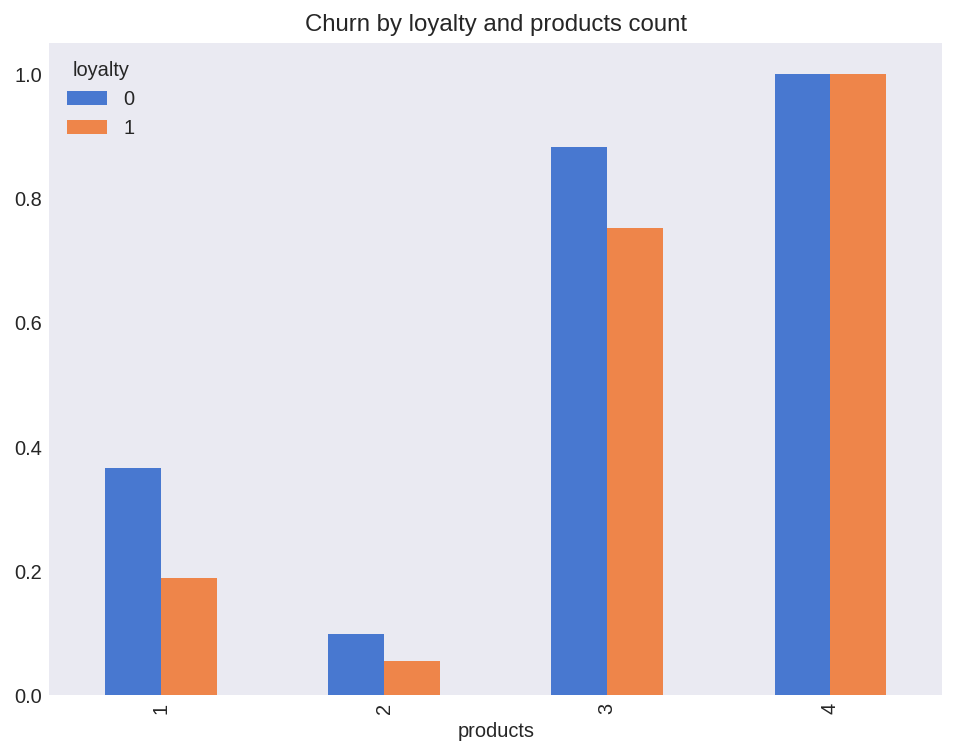

In [15]:
df.pivot_table(index=['products'], columns=['loyalty'], values='churn').plot(kind='bar',
    title = 'Churn by loyalty and products count');

Рассмотрим подробнее отток по возрастам, разделив всех клиентов по периодам в 5 лет. 

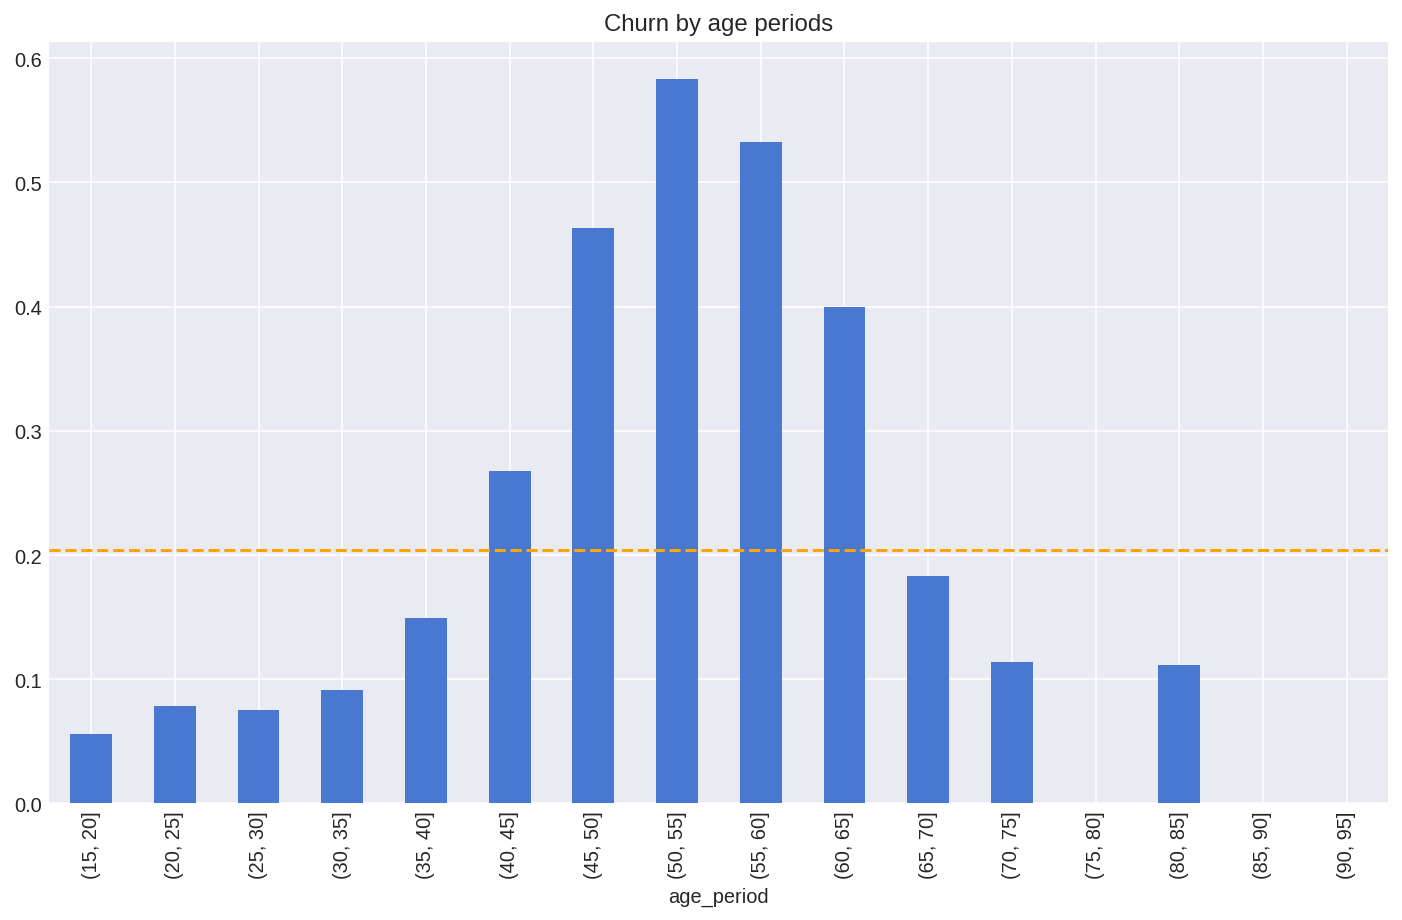

In [16]:
# определяем шаг (5 лет)
step = 5
# определяем нижнюю границу
for i in range(0, df['age'].min(), step):
    if i % step == 0:
        a = i
# определяем верхнюю границу
for k in range(df['age'].max(), (df['age'].max() + step)):
    if k % step == 0:
        b = k + step
# делим все значения от нижней границы до верхней с заданным шагом
cut_bins = list(range(a, b, step))
df['age_period'] = pd.cut(df['age'],
                       bins=cut_bins)

# построим график оттока по возрастным периодам с отметкой среднего оттока по всему сету
plt.figure(figsize=(12, 7))
df.groupby('age_period')['churn'].mean().plot(kind='bar', grid=True, title='Churn by age periods')
plt.axhline(y=df['churn'].mean(), color='orange', linestyle='--');

По графику заметно существенное увеличение оттока относительно средних показателей в период с 41 до 65 лет. Особенно интенсивный отток (более 50%) характерен для периода 51-60 лет.  

### Нормальность распределения признаков

Исследуем распределение признаков на нормальность с помощью графика оценки одномерного распределения по выборке - `distplot`.
Рассмотрим отдельно распределения для ушедших и оставшихся клиентов. 

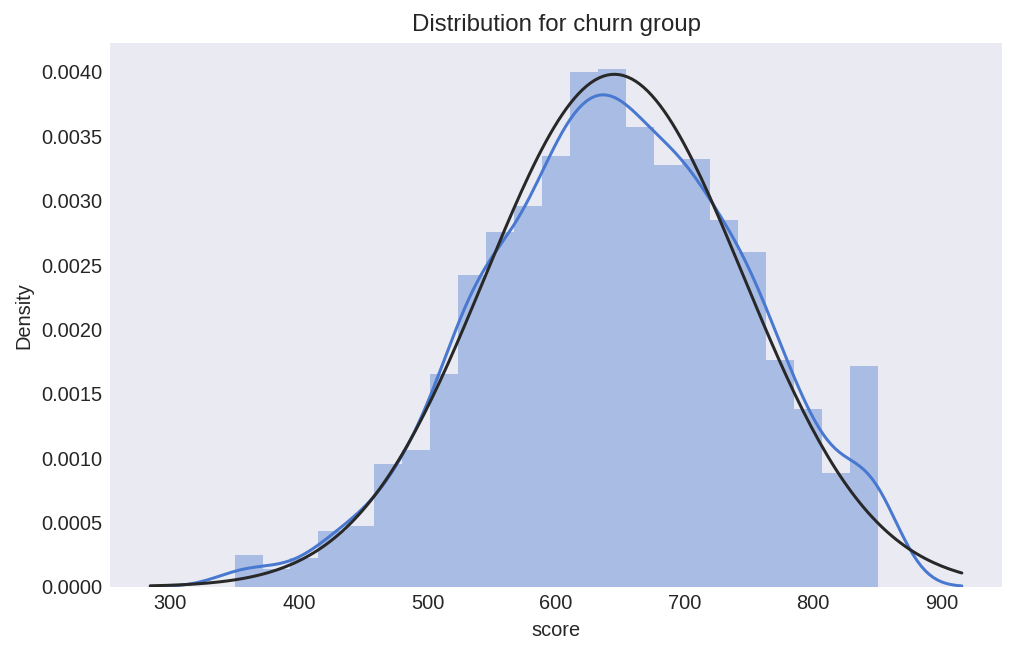

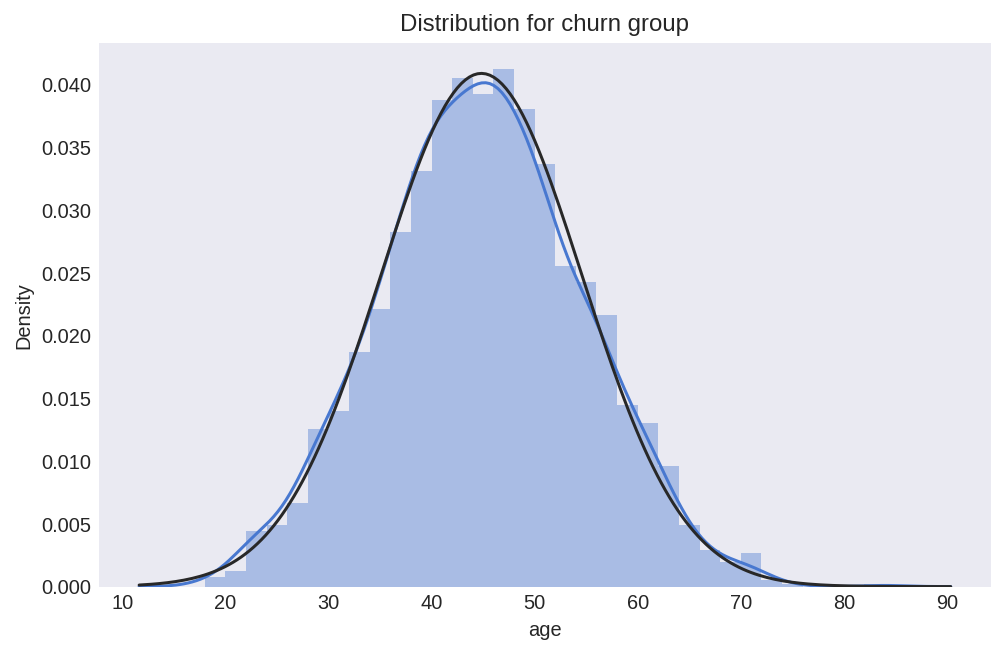

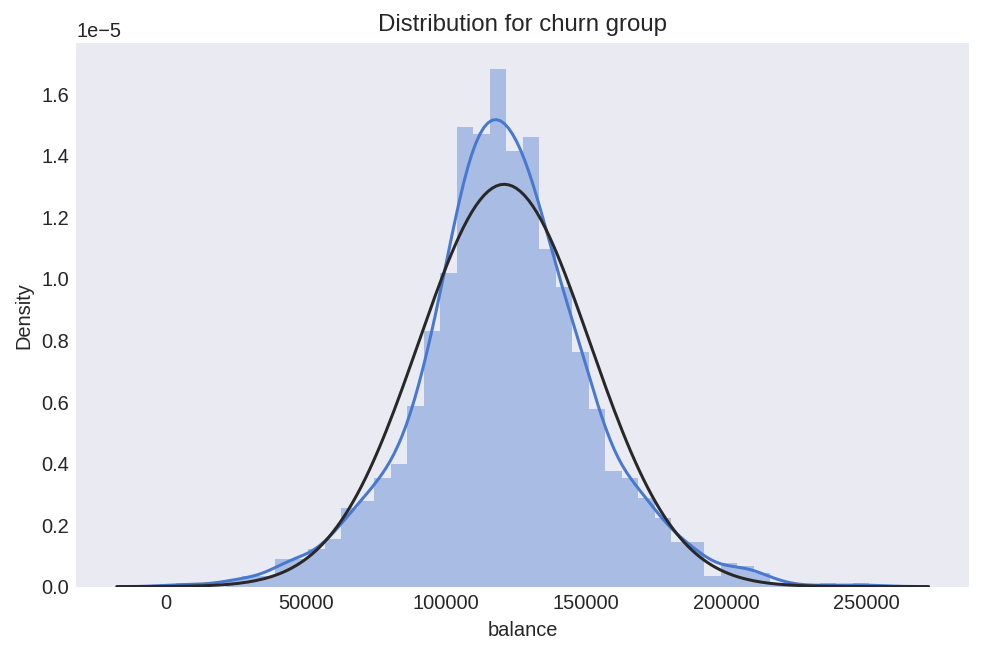

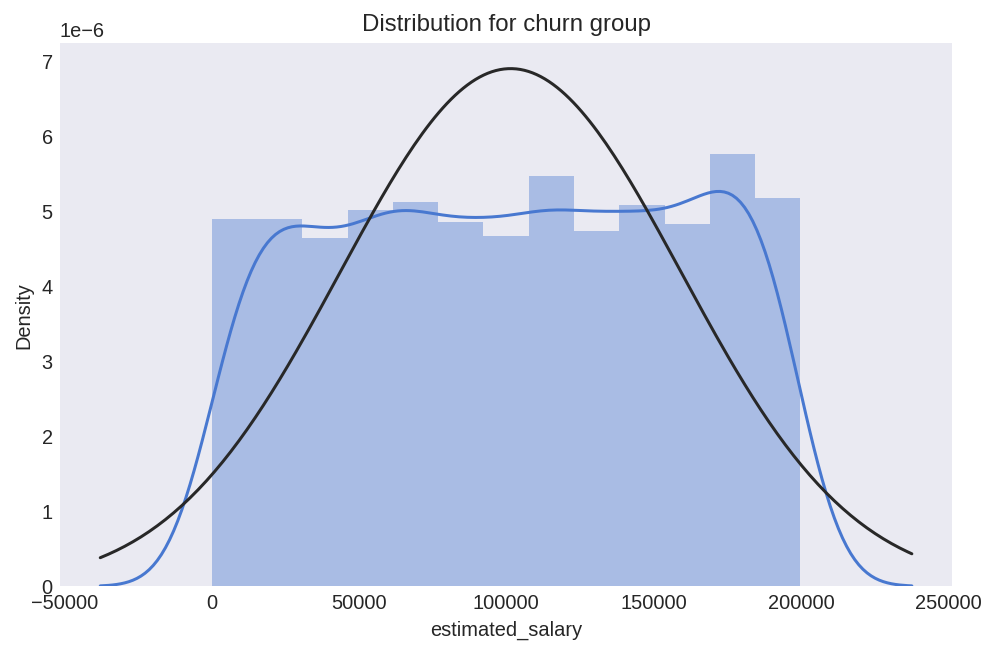

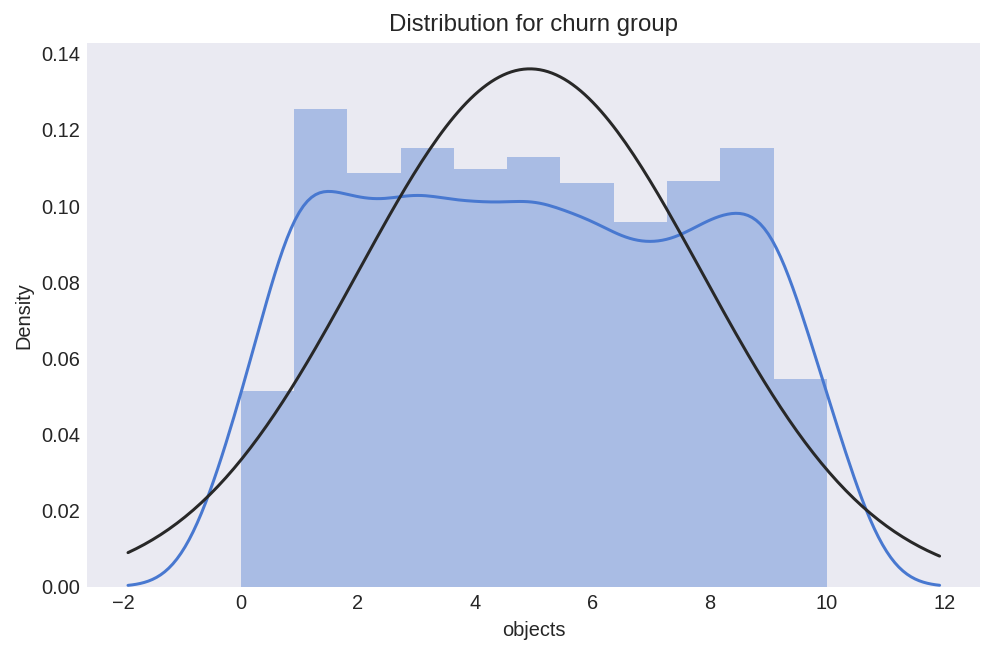

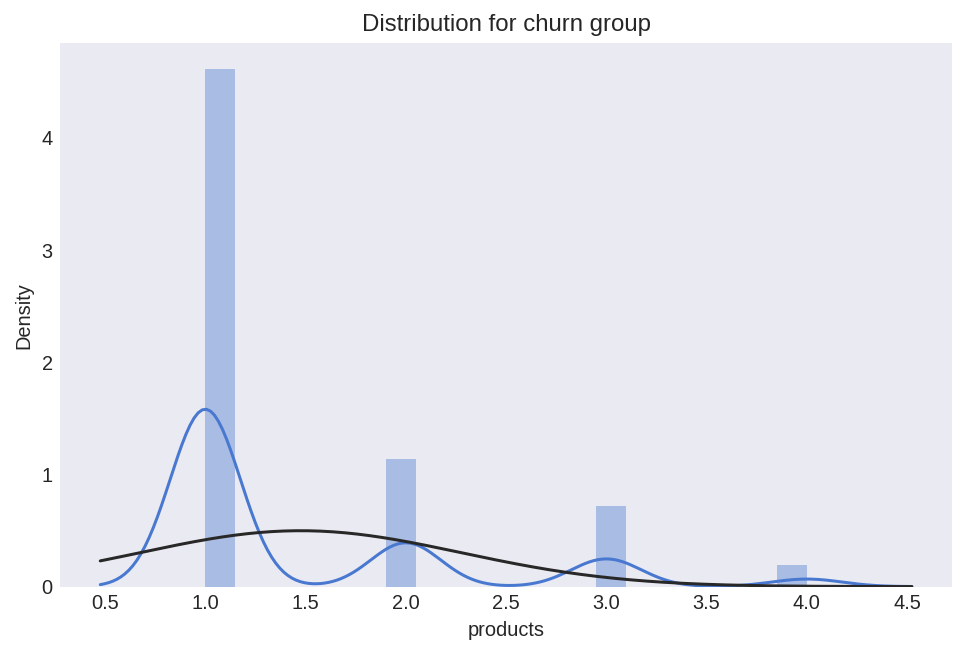

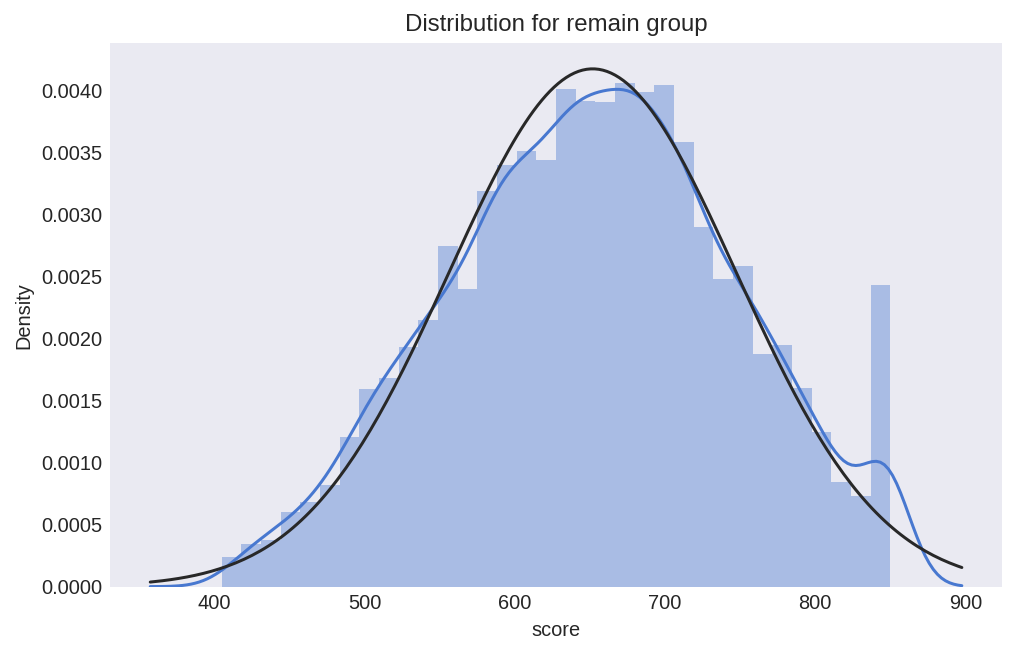

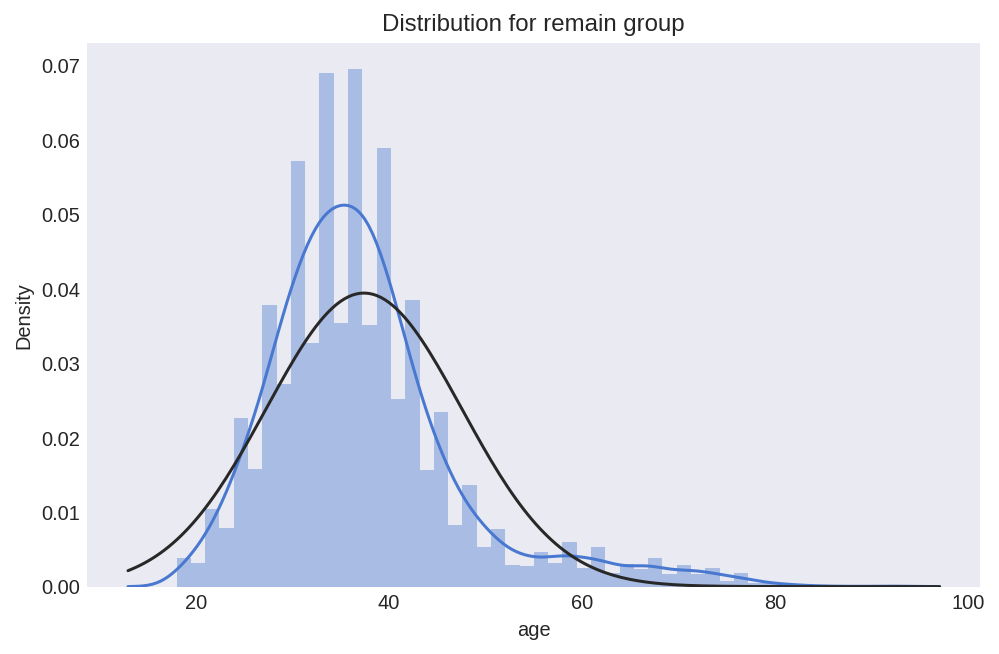

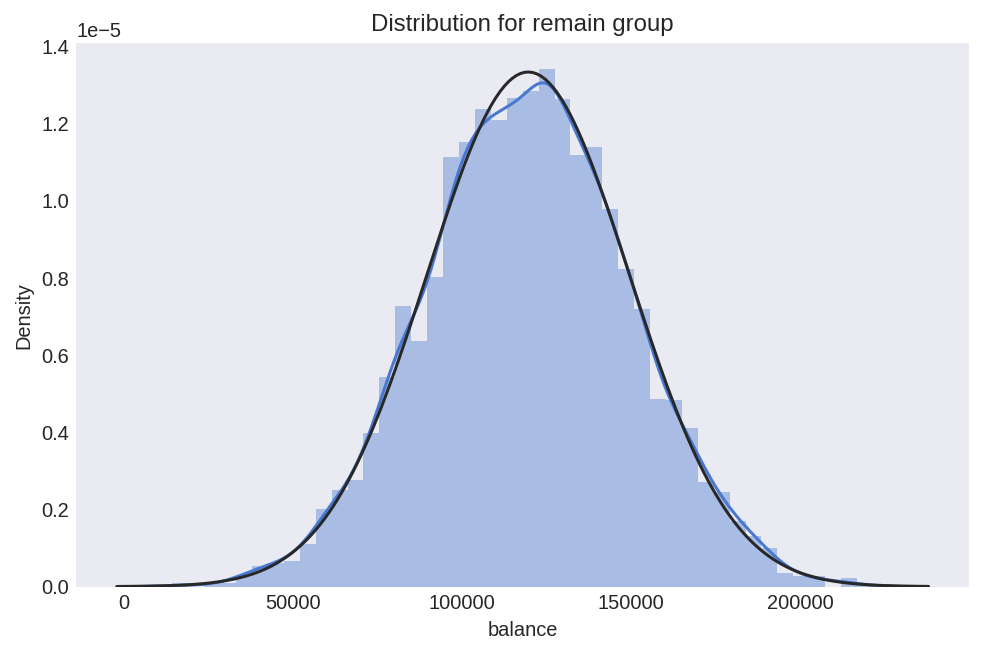

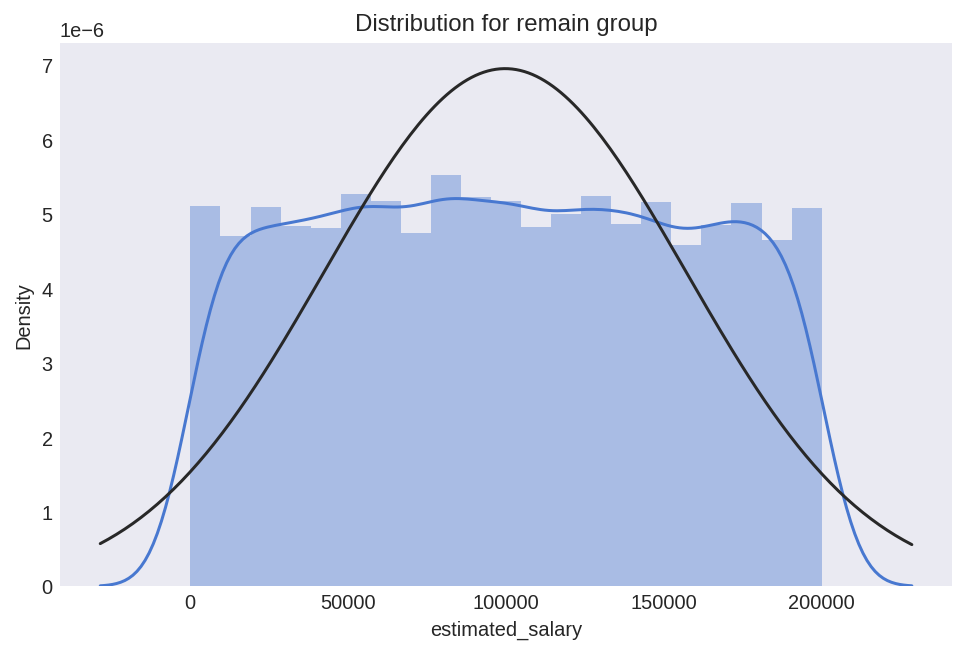

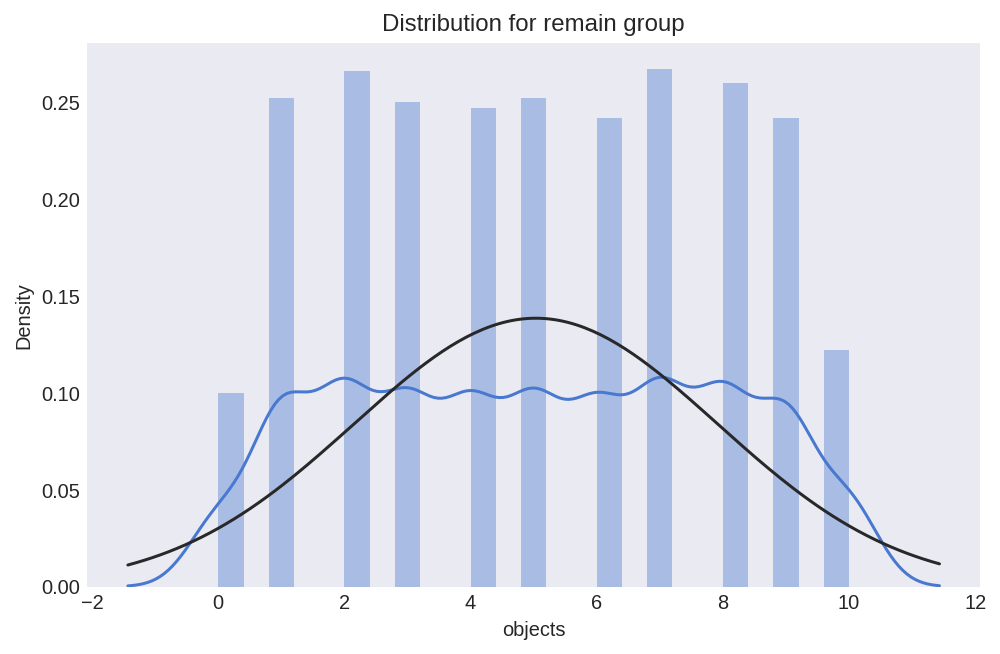

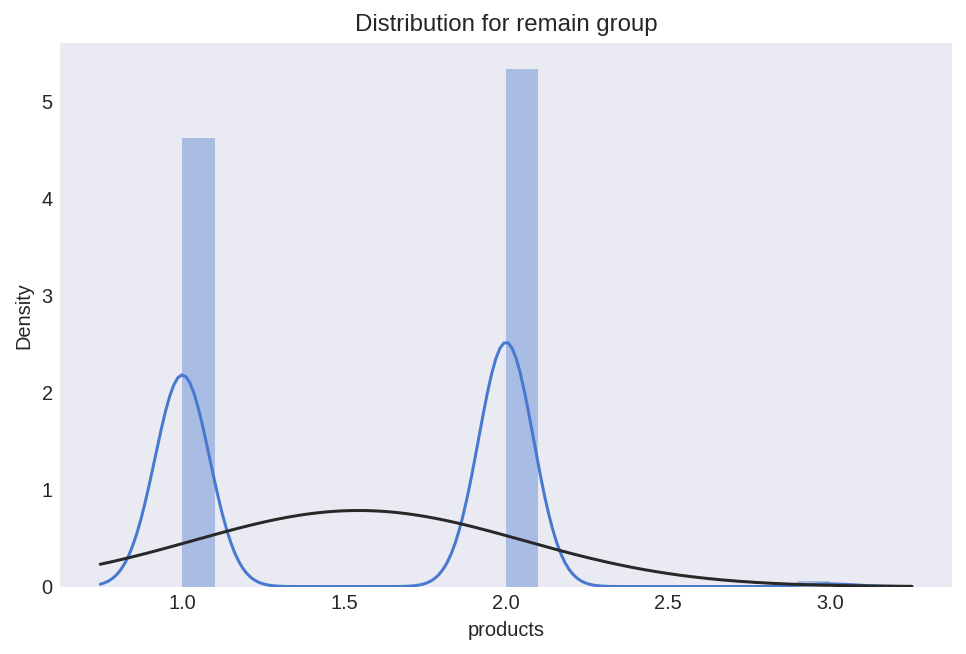

In [17]:
df_churn = df.query('churn == 1')
df_remain = df.query('churn == 0')

distribution_col = ['score', 'age', 'balance', 'estimated_salary', 'objects', 'products']
for col in distribution_col:
    plt.figure(figsize=(8, 5))
    sns.distplot(df_churn[col], fit=st.norm).set_title('Distribution for churn group')
    plt.show();
for col in distribution_col:
    plt.figure(figsize=(8, 5))
    sns.distplot(df_remain[col], fit=st.norm).set_title('Distribution for remain group')
    plt.show();

Распределения возраста ушедших клиентов и баланса оставшихся похожи на нормальные. 

Распределение остальных признаков в той или иной степени отличается от нормального.

### Корреляция признаков.

Определим степень корреляции представленных в сете признаков. 

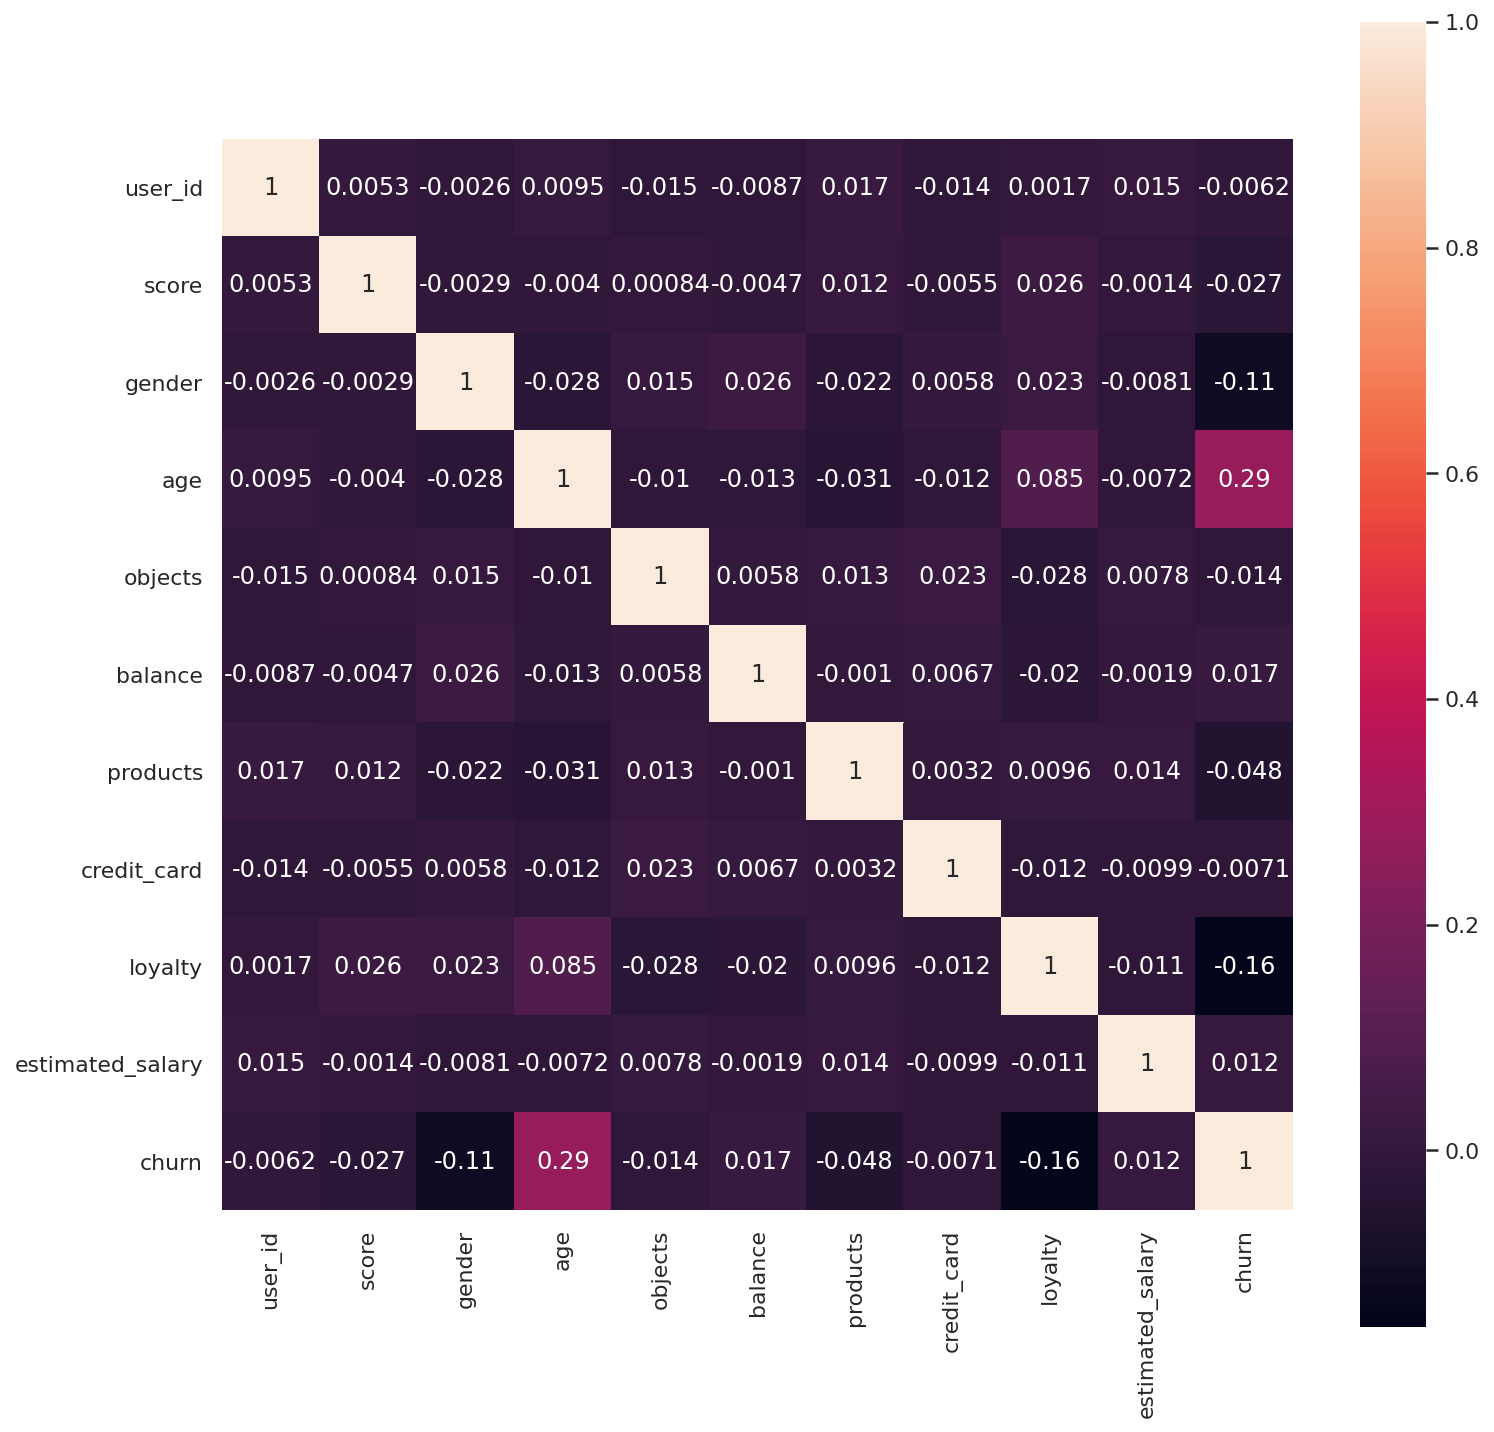

In [18]:
dm = df.corr()
sns.set(rc = {'figure.figsize':(12,12)})
sns.heatmap(dm, annot=True, square=True);

По графику можно выделить 3 слабые корреляции по шкале Чеддока. В порядке уменьшения связи:
- слабая положительная (0,29) - между возрастом и оттоком клиентов: чем старше, тем чаще уходят, 
- слабая отрицательная (-0,16) - между активностью и оттоком: чем активнее, тем реже попадают в отток,
- слабая отрицательная (-0,11) - между полом и оттоком: как было замечено выше, женщины немного чаще уходят в отток. 

### Вывод

- Исходя из анализа представленных данных, заметно, что в отток попадают:
    * все клиенты с низкими скоринговыми баллами до 400 (вероятно те, кто пришел в банк за кредитом и не получил одобрение на его получение)
    * треть всех жителей Ростова Великого. Вероятность оттока в два раза выше, чем для других двух городов. Требуется дополнительный анализ причин высокого оттока именно в этом городе. 
    * чаще женщины, чем мужчины (25% к 16%)
    * существенно чаще клиенты в возрасте 45-65 лет. В интервале 50-57 в отток попадает больше, чем остается. Может быть связано с уходом на пенсию и окончанием зарплатных проектов в банке, либо окончанием выплаты кредитов. Требует дополнительного анализа продуктов банка, которые были использованы этими клиентами.  
    * все клиенты, использующие 4 продукта банка, и бОльшая часть (около 80%) тех, кто использует 3. Число клиентов, использующих 3 и более продукта крайне мало - 3%. Для анализа причин их оттока необходима дополнительная информация о том, какого рода были используемые продукты, и какие из них были добавлены последними. 
    * чаще неактивные клиенты, чем активные (27% к 14%).
    
    
-  Количество объектов в собственности, баланс, наличие кредитной карты и уровень зарплаты существенно не влияют на факт оттока в представленных данных.


- Обнаруженные тенденции независимы.


- Распределения баланса похожи на нормальные. Распределение остальных признаков в той или иной степени отличается от нормального.


- В данных можно выделить 3 слабые корреляции в порядке уменьшения связи:
    - слабая положительная (0,29) - между возрастом и оттоком клиентов: чем старше, тем чаще уходят,
    - слабая отрицательная (-0,16) - между активностью и оттоком: чем активнее, тем реже попадают в отток,
    - слабая отрицательная (-0,11) - между полом и оттоком: как было замечено выше, женщины немного чаще уходят в отток.

## Проверка гипотез.

### Проверка гипотезы о различии дохода ушедших и оставшихся клиентов.

Можно утверждать, что перед нами независимые выборки пользователей (судя по числу уникальных идентификаторов пользователей в сете). Однако распределение значений предполагаемого уровня зарплаты не является нормальным, поэтому применим непараметрический тест Манна-Уитни.

Введем основную и альтернативные гипотезы:

* Н0 - Средний уровень дохода для ушедших и оставшихся клиентов не отличается.
* Н1 - Средний уровень дохода для ушедших и оставшихся клиентов различен.

Уровень значимости:  α=0.05 

Посчитаем p-value, используя `mannwhitneyu` из библиотеки `scipy` для сравнения средних двух выборок.

Если p-value будет меньше выбранного уровня значимости  α=0.05 , то нулевую гипотезу о равенстве дохода отвергнем. Иначе сделаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [19]:
alpha = .05

results = st.mannwhitneyu(df_churn['estimated_salary'],
                          df_remain['estimated_salary'],
                          alternative='two-sided')
print(f'p-значение признака \"estimated_salary\": ', '{0:.3f}'.format(results.pvalue))
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение признака "estimated_salary":  0.227
Не получилось отвергнуть нулевую гипотезу


Итак, исходя из текущих данных и уровня значимости 0,05 нам не удалось отвергнуть нулевую гипотезу, согласно которой **"Средний уровень дохода для ушедших и оставшихся клиентов не отличается"**

### Проверка гипотезы о различии баланса ушедших и оставшихся клиентов.

Для проверки данной гипотезы нам необходимо будет взять данные, очищенные от пробелов признака `balance` - `df_not_isna`, поскольку сравнивать пропущенные значения мы не можем.  

Проверим гипотезу о различиях дохода между теми клиентами, которые ушли и теми, которые остались. Создадим два соответствующих сета из данных с заполненным балансом. Проверим распределение баланса в них на нормальность с помощью теста Шапиро-Уилка. 

- Н0 - распределение нормально
- Н1 - распределение отличается от нормального 

In [20]:
df_not_isna_churn = df_not_isna.query('churn == 1')
df_not_isna_remain = df_not_isna.query('churn == 0')

alpha = .05

results = st.shapiro(df_not_isna_churn['balance'])
p_value = results[1]

print ('p-значение баланса группы оттока: ', p_value)

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: распределение не нормально")
else:
    print("Не получилось отвергнуть нулевую гипотезу: распределение нормально")

print(90*'-')
results = st.shapiro(df_not_isna_remain['balance'])
p_value = results[1]

print ('p-значение баланса группы оставшихся клиентов: ', p_value)

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: распределение не нормально")
else:
    print("Не получилось отвергнуть нулевую гипотезу: распределение нормально")

p-значение баланса группы оттока:  1.0646013848258917e-08
Отвергаем нулевую гипотезу: распределение не нормально
------------------------------------------------------------------------------------------
p-значение баланса группы оставшихся клиентов:  0.8506813049316406
Не получилось отвергнуть нулевую гипотезу: распределение нормально


Можно утверждать, что перед нами независимые выборки пользователей (судя по числу уникальных идентификаторов пользователей в сете). Распределение значений баланса распределено нормально только в группе оставшихся клиентов, поэтому применим непараметрический тест Манна-Уитни.

Введем основную и альтернативные гипотезы:

* Н0 - Средний уровень баланса для ушедших и оставшихся клиентов не отличается.
* Н1 - Средний уровень баланса для ушедших и оставшихся клиентов различен.

Уровень значимости:  α=0.05 

Посчитаем p-value, используя `mannwhitneyu` из библиотеки `scipy` для сравнения средних двух выборок.

Если p-value будет меньше выбранного уровня значимости  α=0.05 , то нулевую гипотезу о равенстве баланса отвергнем. Иначе сделаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [21]:
alpha = .05

results = st.mannwhitneyu(df_not_isna_churn['balance'],
                          df_not_isna_remain['balance'],
                          alternative='two-sided')
print(f'p-значение признака \"balance\": ', '{0:.3f}'.format(results.pvalue))
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение признака "balance":  0.222
Не получилось отвергнуть нулевую гипотезу


Итак, исходя из текущих данных и уровня значимости 0,05 нам не удалось отвергнуть нулевую гипотезу, согласно которой **"Средний уровень баланса ушедших и оставшихся клиентов не отличается"**

### Проверка других гипотез

Для надежности проверим гипотезы о различиях по всем остальным признакам. Опираясь на ранее полученные сведения о данных, предположим, что **"Средний балл кредитного скоринга, пол, количество продуктов и активность выше у оставшихся клиентов, а возраст, число объектов недвижимости и вероятность наличия кредитной карты ниже"**

Используем непараметрический тест Манна-Уитни, поскольку распределение вышеперечисленных признаков отличается от нормального.

Сформулируем гипотезы для проверки первой части предположений.

* Н0 - Средний балл кредитного скоринга, пол, количество продуктов и активность для ушедших и оставшихся клиентов не отличается.
* Н1 - Средний балл кредитного скоринга, пол, количество продуктов и активность оставшихся клиентов выше аналогичных показателей ушедших клиентов.

Уровень значимости: α=0.05

Если p-value будет меньше выбранного уровня значимости α=0.05 , то нулевую гипотезу о равенстве средних отвергнем. Иначе сделаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [22]:
greater_col = ['score', 'gender', 'products', 'loyalty']

alpha = .05

for col in greater_col:
    results = st.mannwhitneyu(df_remain[col],
                              df_churn[col],
                              alternative='greater')
    print(f'p-значение признака \"{col}\": ', '{0:.3f}'.format(results.pvalue))
    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")
    print (90*'-')

p-значение признака "score":  0.010
Отвергаем нулевую гипотезу
------------------------------------------------------------------------------------------
p-значение признака "gender":  0.000
Отвергаем нулевую гипотезу
------------------------------------------------------------------------------------------
p-значение признака "products":  0.000
Отвергаем нулевую гипотезу
------------------------------------------------------------------------------------------
p-значение признака "loyalty":  0.000
Отвергаем нулевую гипотезу
------------------------------------------------------------------------------------------


При текущей проверке гипотез на уровне значимости 0,05 мы отвергли нулевую гипотезу о том, что "Средний балл кредитного скоринга, пол, количество продуктов и активность для ушедших и оставшихся клиентов не отличается" и приняли альтернативную гипотезу, согласно которой **"Средний балл кредитного скоринга, пол, количество продуктов и активность оставшихся клиентов выше аналогичных показателей ушедших клиентов"**

Проверим теперь вторую часть предположения о более низком среднем возрасте, числе объектов недвижимости и вероятности наличия кредитной карты для оставшихся клиентов.

* Н0 - Средний возраст, число объектов недвижимости и вероятность наличия кредитной карты оставшихся и ушедших клиентов не отличается.
* Н1 - Средний возраст, число объектов недвижимости и вероятность наличия кредитной карты оставшихся клиентов ниже аналогичного показателя ушедших клиентов.

Уровень значимости: α=0.05

Если p-value будет меньше выбранного уровня значимости α=0.05 , то нулевую гипотезу о равенстве средних отвергнем. Иначе сделаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [23]:
less_col = ['age', 'objects', 'credit_card']

for col in less_col:
    results = st.mannwhitneyu(df_remain[col],
                              df_churn[col],
                              alternative='less')
    print(f'p-значение признака \"{col}\": ', '{0:.3f}'.format(results.pvalue))
    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")
    print (90*'-')

p-значение признака "age":  0.000
Отвергаем нулевую гипотезу
------------------------------------------------------------------------------------------
p-значение признака "objects":  0.919
Не получилось отвергнуть нулевую гипотезу
------------------------------------------------------------------------------------------
p-значение признака "credit_card":  0.762
Не получилось отвергнуть нулевую гипотезу
------------------------------------------------------------------------------------------


В ходе статистической проверки на уровне значимости 0,05 мы отвергли нулевую гипотезу о том, что "Средний возраст оставшихся и ушедших клиентов не отличается" и приняли альтернативную гипотезу, согласно которой **"Средний возраст оставшихся ниже аналогичного показателя ушедших клиентов."**

Гипотезы о различиях числа объектов недвижимости и вероятности наличия кредитной карты мы отвергнуть не можем, поэтому принимаем гипотезу, согласно которой **Число объектов недвижимости и вероятность наличия кредитной карты оставшихся и ушедших клиентов не отличается**

### Вывод

По проведенным статистическим тестам можно сделать вывод о том, что 

**группа ушедших клиентов отличается** от группы оставшихся клиентов по следующим признакам:
- среднему баллу кредитного скоринга - в группе оттока ниже, 
- полу - в группе оттока больше женщин, 
- возрасту - в группе оттока клиенты старше, 
- количеству продуктов - в группе оттока их число выше, 
- активности - в группе оттока активность ниже.

Клиенты группы оттока и оставшиеся **не отличаются по:**
- предполагаемому уровню зарплаты,
- уровню баланса,
- количеству объектов недвижимости, 
- наличию кредитной карты.

## Построение модели бинарной классификации по признаку оттока.

### Преобразование данных для построения моделей.

Преобразуем категориальные признаки в числовые. Удалим из нового сета неактуальный признак возрастного периода и id пользователей. Переименуем новые признаки. 

In [24]:
df_num = pd.get_dummies(df.drop(['user_id', 'age_period'], axis=1))
display(df_num.columns)
df_num.rename(columns={'city_Ростов Великий': 'Rostov',
                       'city_Рыбинск': 'Rybinsk',
                       'city_Ярославль': 'Yaroslavl'}, inplace=True)
df_num.sample(5)

Index(['score', 'gender', 'age', 'objects', 'balance', 'products',
       'credit_card', 'loyalty', 'estimated_salary', 'churn',
       'city_Ростов Великий', 'city_Рыбинск', 'city_Ярославль'],
      dtype='object')

,score,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,Rostov,Rybinsk,Yaroslavl
3541,838,0,67,4,"103,267.80",1,1,1,"78,310.04",0,0,1,0
4278,759,1,30,4,"101,802.67",1,0,0,"8,693.80",0,1,0,0
6559,533,1,38,4,"70,362.52",2,1,1,"104,189.46",0,1,0,0
7335,651,0,41,4,"38,617.20",1,1,1,"104,876.80",0,0,0,1
5297,572,1,51,8,"97,750.07",3,1,1,"193,014.26",1,1,0,0


Поскольку статистически значимых различий баланса в группе ушедших и оставшихся клиентов не обнаружено, мы можем удалить данный столбец для дальнейшей обработки данных моделью, посколько нам необходимы данные без пропусков. 

In [25]:
# Создадим перменные с вектором признаков (X) и значениями целевой переменной (y).
X = df_num.drop(['churn','balance'], axis=1)
y = df_num['churn']

# Разобъем данные на обучающую и валидационную выборку в пропорции 80/20, сохранив пропорции по оттоку.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

# Применим стандартизацию, поскольку планируем использовать чувствительные к стандартизации модели
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

### Обучение и сравнение моделей

Обучим модель на train-выборке 4 способами:
  - логистической регрессией
  - деревом принятия решений
  - случайным лесом 
  - градиентным бустингом.

In [26]:
def make_prediction (m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:,1]
    print ('''
    Доля правильных ответов: {:.2f}, 
    Точность: {:.2f},
    Полнота: {:.2f},
    F1-мера: {:.2f},
    Площадь под кривой ошибок: {:.2f}
    '''
           .format(accuracy_score(y_test, y_pred), 
                   precision_score(y_test, y_pred), 
                   recall_score(y_test, y_pred),
                   f1_score(y_test, y_pred),
                   roc_auc_score(y_test, probabilities)
    ))    
models = [LogisticRegression(random_state=0),
          DecisionTreeClassifier(random_state=0),
          RandomForestClassifier(random_state=0),
          GradientBoostingClassifier(random_state=0)]
for i in models:
    print (i)
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)

LogisticRegression(random_state=0)

    Доля правильных ответов: 0.81, 
    Точность: 0.59,
    Полнота: 0.23,
    F1-мера: 0.33,
    Площадь под кривой ошибок: 0.76
    
DecisionTreeClassifier(random_state=0)

    Доля правильных ответов: 0.78, 
    Точность: 0.46,
    Полнота: 0.46,
    F1-мера: 0.46,
    Площадь под кривой ошибок: 0.66
    
RandomForestClassifier(random_state=0)

    Доля правильных ответов: 0.85, 
    Точность: 0.73,
    Полнота: 0.43,
    F1-мера: 0.55,
    Площадь под кривой ошибок: 0.82
    
GradientBoostingClassifier(random_state=0)

    Доля правильных ответов: 0.85, 
    Точность: 0.75,
    Полнота: 0.43,
    F1-мера: 0.55,
    Площадь под кривой ошибок: 0.84
    


По текущим данным одной из самых сильных по полноте моделей является "Дерево принятия решений" (DecisionTreeClassifier). Полнота позволяет нам не пропустить бОльшую часть тех клиентов, которые могут попасть в отток. Та же модель - одна из самых легко интерпретирумых. Попробуем улучшить ее метрики, уменьшив переобучение. 

In [27]:
# параметры модели подобраны в результате компромисса между 
# показателями метрик и наглядностью последующей визуализации

tree_model = DecisionTreeClassifier(random_state=0, max_depth=2, 
                                    max_leaf_nodes=10, min_samples_leaf=50)

# используем нестандартизированные данные для интерпретируемости
tree_model.fit(X_train, y_train)
y_pred = tree_model.predict(X_test)
probabilities = tree_model.predict_proba(X_test)[:,1]

print ('''
    Доля правильных ответов: {:.2f}, 
    Точность: {:.2f},
    Полнота: {:.2f},
    F1-мера: {:.2f},
    Площадь под кривой ошибок: {:.2f}
    '''
       .format(accuracy_score(y_test, y_pred), 
        precision_score(y_test, y_pred), 
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        roc_auc_score(y_test, probabilities)))    


    Доля правильных ответов: 0.82, 
    Точность: 0.60,
    Полнота: 0.42,
    F1-мера: 0.49,
    Площадь под кривой ошибок: 0.71
    


Подобранные параметры модели позволили улучшить долю правильных ответов, точность, F1-меру и площадь под кривой ошибок. 

Нарисуем получившееся дерево принятия решений для понимания работы модели.

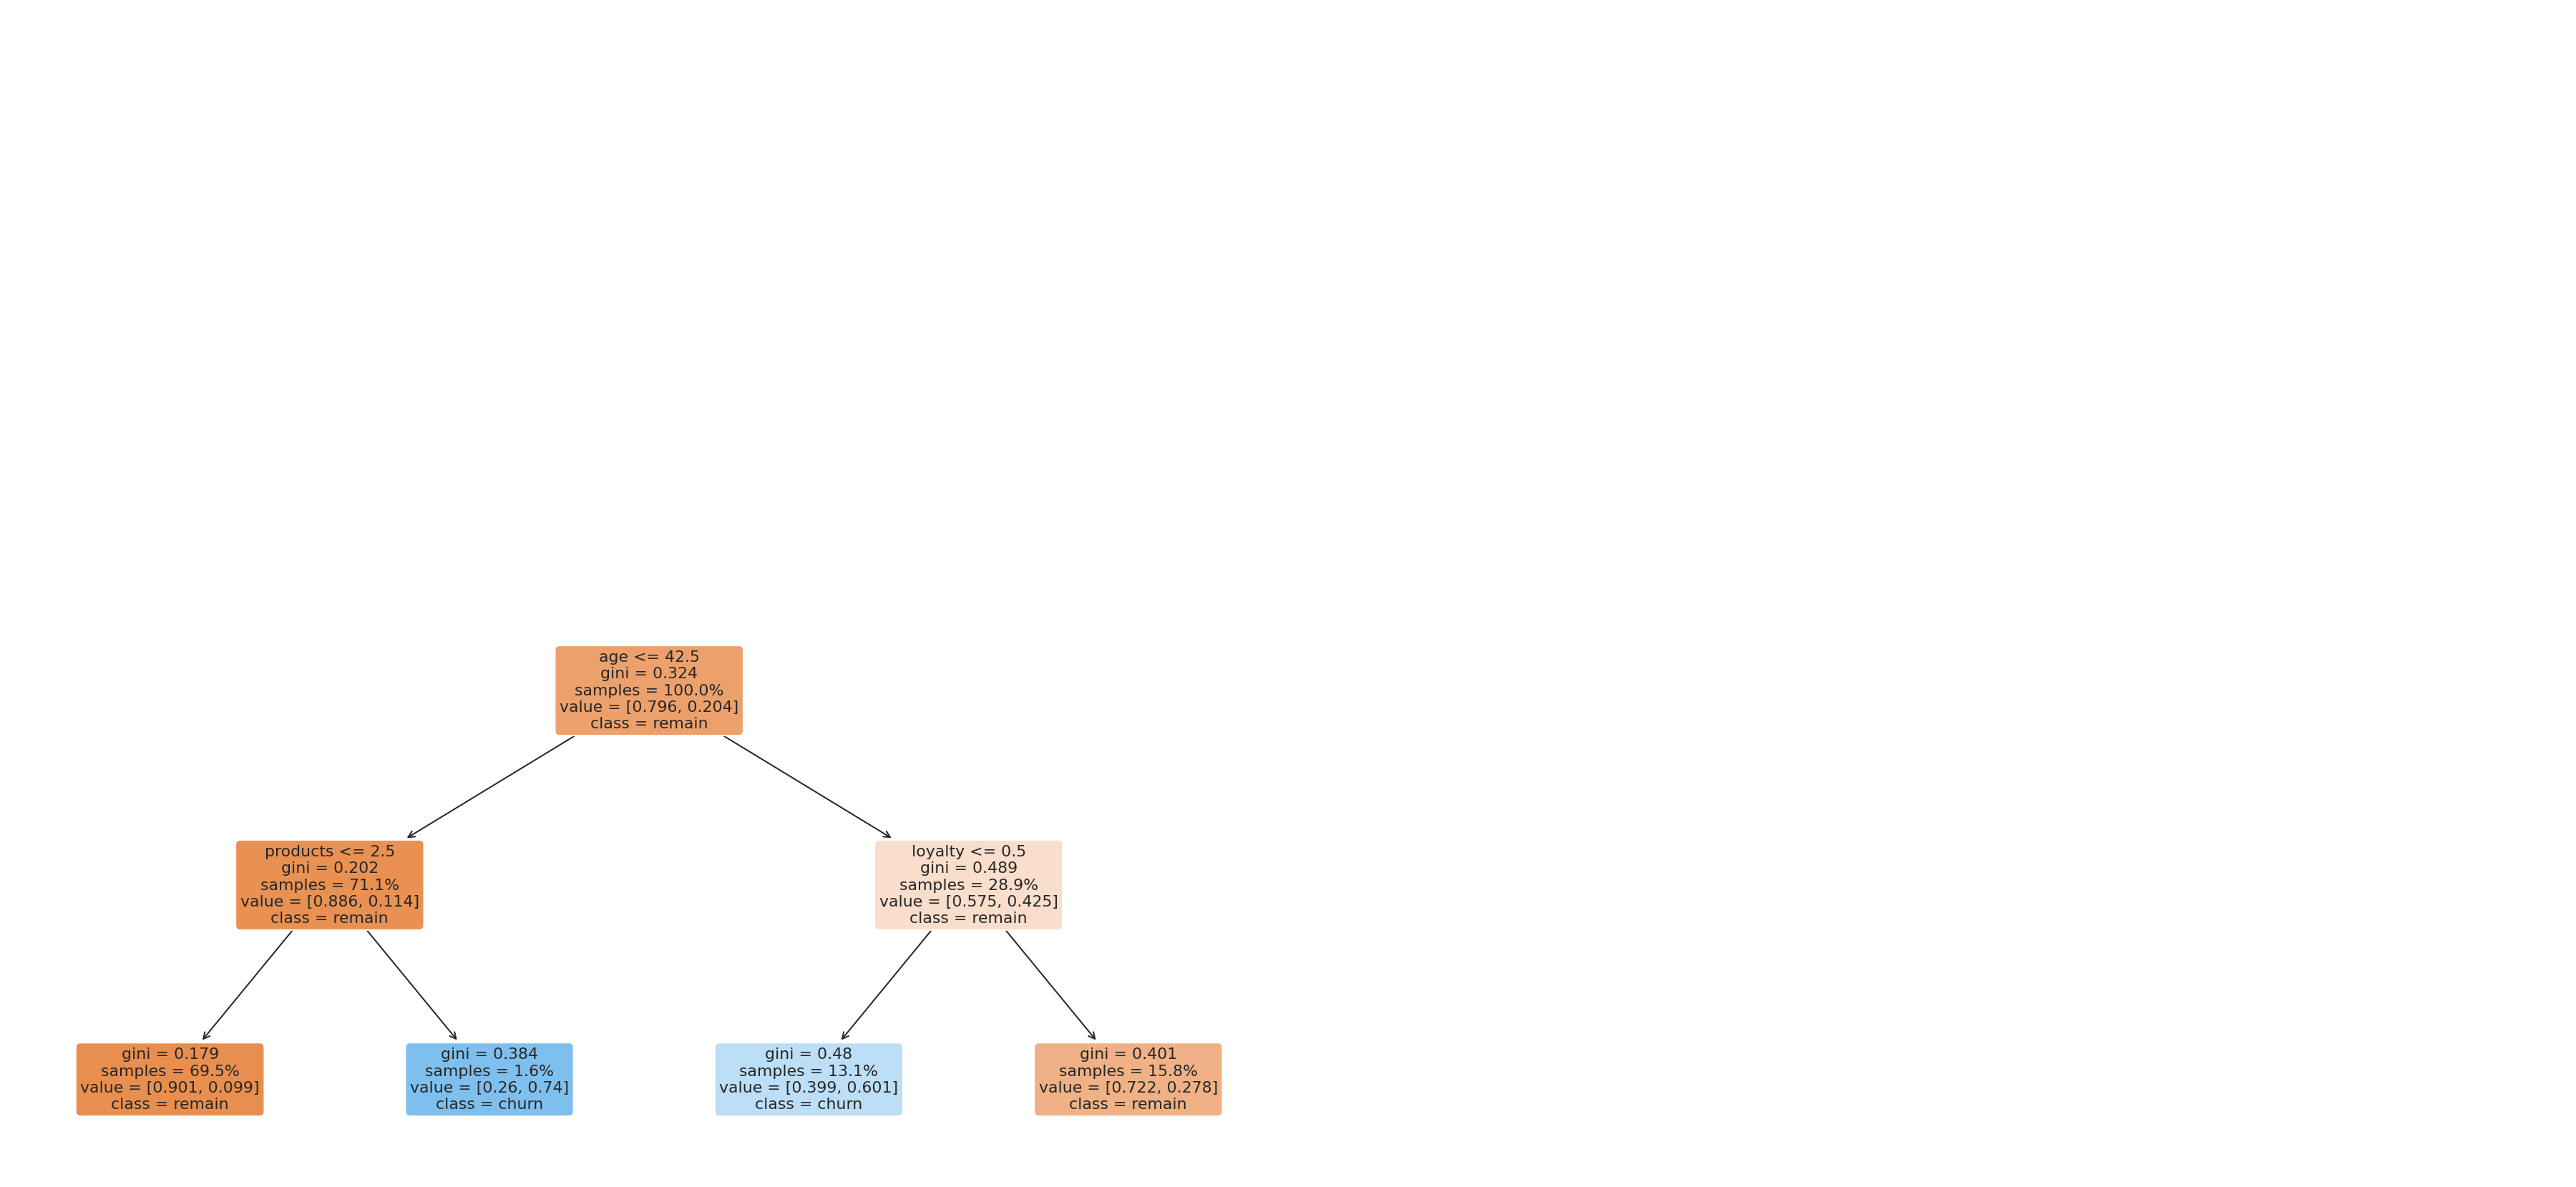

In [28]:
plt.figure(figsize=(32, 15))
plot_tree(tree_model, feature_names=X_train.columns, filled=True, 
          class_names=['remain', 'churn'], fontsize=11,
          rounded=True, proportion=True)
plt.savefig('tree_high_dpi', dpi=100);

В результате визуализации видим, что решающим параметром при делении клиентов на уходящих и остающихся, является возраст, далее критериями выступают число продуктов и активность. Следовательно, данные параметры являются определяющими для классификации клиентов по признаку оттока. 

Прояснив особенности работы модели, можно переходить к их ансамблям, которые позволят увидеть параметры, влияющие на отток и определить степень их влияния. 

Возьмем модель "Градиентного бустинга" (GradientBoostingClassifier), как лучшую по площади под кривой ошибок, попытаемся ее улучшить, изменив гиперпараметры. 

In [29]:
ansamble_model = GradientBoostingClassifier(random_state=0, max_depth=4, 
                                            min_samples_leaf=27, min_samples_split=4)
ansamble_model.fit(X_train, y_train)
y_pred = ansamble_model.predict(X_test)
probabilities = ansamble_model.predict_proba(X_test)[:,1]

print ('''
    Доля правильных ответов: {:.2f}, 
    Точность: {:.2f},
    Полнота: {:.2f},
    F1-мера: {:.2f},
    Площадь под кривой ошибок: {:.2f}
    '''
       .format(accuracy_score(y_test, y_pred), 
        precision_score(y_test, y_pred), 
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        roc_auc_score(y_test, probabilities)))


    Доля правильных ответов: 0.86, 
    Точность: 0.76,
    Полнота: 0.44,
    F1-мера: 0.56,
    Площадь под кривой ошибок: 0.84
    


Использование настраиваемых параметров позволило незначительно увеличить долю правильных ответов, точность, полноту и F1-меру модели и не повлияло на показатели кривой ошибок. 

Посмотрим, какие параметры модель посчитала наиболее значимыми при классификации.

In [30]:
feature_data = pd.DataFrame(data={'feature': X.columns,
                                  'importance': ansamble_model.feature_importances_})
print (feature_data.sort_values(by='importance', ascending=False)) 

             feature  importance
2                age        0.42
4           products        0.30
6            loyalty        0.11
8             Rostov        0.05
7   estimated_salary        0.05
0              score        0.03
1             gender        0.02
3            objects        0.01
10         Yaroslavl        0.00
5        credit_card        0.00
9            Rybinsk        0.00


Исходя из модели "Градиентного бустинга" наиболее важными параметрами разделения клиентов на ушедших и оставшихся можно считать (в порядке уменьшения значимости):

* возраст
* число используемых продуктов
* активность

Остальные параметры имеют малый вес при классификации. 

### Вывод

В ходе построения модели бинарной классификации по признаку оттока были выделены наиболее важные критерии оттока по двум разным моделям. 

**1. Модель "Дерево принятия решений"** (DecisionTreeClassifier) дает нам легко интерпертируемый вариант ветвления на основе показателей возраста, активности и числа используемых продуктов. 

Согласно этой модели, есть 2 основных пути попадания в группу оттока:
- возраст до 42 лет включительно, число используемых продуктов 3 и более.
- возраст от 43 лет, активность ниже или равная среднему уровню

Данная модель может быть использована в случае, если принятие решения о возможном попадании клиента в отток контролируется извне и должна быть объяснима. А также для эмпирического поиска покидающих банк клиентов. 

Рассмотрев особенности работы первой модели, мы можем перейти ко второй, которая лучше описывает признаки оттока за счет последовательного обучения большого числа деревьев. 

**2. Модель "Градиентного бустинга"** (GradientBoostingClassifier) предоставляет нам список параметров со степенью их важности при определении оттока: 

- Возраст - наиболее важен (показатель 0,42)
- Число используемых продуктов (0,3)
- Активность (0,11)

Модели не противоречат друг другу, следовательно, любая из них может быть использована.

Так, например, для эмпирического выявления уходящих клиентов, рекомендуется первая модель "Дерево принятия решений", как более понятная и объяснимая.

При внедрении автоматического прогноза оттока клиентов рекомендуется использование второй модели "Градиентного бустинга", как лучшей по уровню точности, полноты и менее подверженной ошибкам. Она позволит упустить меньшее число клиентов и даст шанс удержать тех, кто склонен уйти в отток. 

## Выводы и презентация исследования

### Выводы и рекомендации

В ходе **ознакомления с данными** изучен сет из 10 000 записей по 12 признакам. Присутствуют многочисленные пропуски признака `balance` (более 30%), которые оставлены без изменений. 

Особенности признаков: 
- `score` - баллы кредитного скоринга от 350 до 850, без явных выбросов (медиана и среднее примерно на одном уровне - 650)
- `city` - представлены клиенты 3-х городов: Ярославля (5014 клиентов) - более 50% сета, Ростова Великого (2509) - около 25% и Рыбинска (2477) - около 25%.
- `gender` - клиенты мужского пола встречаются в данных немного чаще, чем женского (55% против 45%)
- `age` - возраст клиентов от 18 до 92 лет со средним значением 38.92 и медианным 37 лет
- `objects` - количество объектов в собственности от 1 до 10 (среднее и медиана - 5)
- `balance` - баланс счета от 3 768.69 до 250 898.09, без явных выбросов (среднее и медиана около 120 000)
- `products` - количество используемых продуктов банка от 1 до 4, присутствуют выбивающиеся значения - среднее (1,53) больше медианы (1)
- `credit_card` - кредитная карта есть у 71% клиентов
- `loyalty` - активными клиентами признаны около половины (52%)
- `estimated_salary` - предполагаемый уровень заработной платы от 11.58 до 199 992.48 со средним и медианой около 100 000
- `churn` - отток клиентов за исследуемый период составил 20% 
    
Проведенный **исследовательский анализ данных** позволил заметить, что в отток попадают: 

* все клиенты с низкими скоринговыми баллами до 400 (вероятно те, кто пришел в банк за кредитом и не получил одобрение на его получение)
* треть всех жителей Ростова Великого. Вероятность оттока в два раза выше, чем для других двух городов. Требуется дополнительный анализ причин высокого оттока именно в этом городе. 
* чаще женщины, чем мужчины (25% к 16%)
* существенно чаще клиенты в возрасте 45-65 лет. В интервале 50-57 в отток попадает больше, чем остается. Может быть связано с уходом на пенсию и окончанием зарплатных проектов в банке, либо окончанием выплаты кредитов. Требует дополнительного анализа продуктов банка, которые были использованы этими клиентами.  
* все клиенты, использующие 4 продукта банка, и бОльшая часть (около 80%) тех, кто использует 3. Клиентов, использующих 3 и более продукта, в сете около 3%. Для анализа причин их оттока необходима дополнительная информация о том, какого рода были используемые продукты, и какие из них были добавлены последними. 
* чаще неактивные клиенты, чем активные (27% к 14%).

Обнаружены 3 слабые корреляции в порядке уменьшения связи:
- слабая положительная (0,29) - между возрастом и оттоком клиентов: чем старше, тем чаще уходят,
- слабая отрицательная (-0,16) - между активностью и оттоком: чем активнее, тем реже попадают в отток,
- слабая отрицательная (-0,11) - между полом и оттоком: как было замечено выше, женщины немного чаще уходят в отток.

**Проверка статистических гипотез** о влиянии признаков на отток выявила, что группа ушедших клиентов отличается от группы оставшихся клиентов по следующим признакам:
- среднему баллу кредитного скоринга - в группе оттока ниже, 
- полу - в группе оттока больше женщин, 
- возрасту - в группе оттока клиенты старше, 
- количеству используемых продуктов - в группе оттока их число выше, 
- активности - в группе оттока активность ниже.

В то же время группы оставшихся клиентов и оттока не отличаются по уровню дохода, балансу средств, количеству объектов недвижимости и наличию кредитной карты.

Построенная **модель бинарной классификации по признаку оттока** выявила портреты клиентов, которые склонны уходить: 
- возраст до 42 лет включительно, число используемых продуктов 3 и более.
- возраст от 43 лет, активность ниже или равная среднему уровню

Дополнительная модель классификации выделила следующие признаки, значимые при определении вероятности оттока: 
- Возраст - наиболее важен (показатель 0,42)
- Число используемых продуктов (0,3)
- Активность (0,11)





Исходя из результатов исследования, **можно рекомендовать**:

1. Дальнейший анализ причин высокого оттока среди жителей города Ростова Великого (возможно, имеет смысл внутренний аудит и дополнительный опрос клиентов о трудностях, с которыми они сталкиваются)


2. Выявление причин повышенного оттока среди клиентов-женщин.


3. Мониторинг активности клиентов (возможен отток неактивных клиентов).


4. Дополнительное исследование продуктов, после добавления которых клиенты уходят из банка.


5. Активное взаимодействие и предложения о продолжении сотрудничества для клиентов 45-65 лет, которые завершают использование одного из продуктов. 


6. Особенно пристальное внимание клиентам, попадающим в группы риска, согласно модели классификации клиентов: 
- возраст до 42 лет включительно, число используемых продуктов 3 и более.
- возраст от 43 лет, активность ниже или равная среднему уровню

7. Внедрение автоматизированной модели определения вероятности оттока. 

### Визуализация

Дополнительно исследовать ситуацию оттока и признаки клиентов позволит представленный **дашборд**: 
https://public.tableau.com/app/profile/mary2727/viz/New_ya_bank_churn/sheet2

Визуализация **Количество клиентов по числу используемых продуктов** показывает

- Процент оттока клиентов (обозначен цветом, вынесен в подпись и во всплывающую подсказку к данным).
- Число клиентов по количеству используемых продуктов (также в подписи и подсказке).

Визуализация **Количество клиентов и отток по возрастам** показывает

- Число клиентов данного возраста (в подписи данных)
- Процент оттока в этом возрасте от общего числа клиентов.


**По всем преставленным графикам** может быть выбран:
- город из списка (поле в вехней части слева, может быть выбрано любое число городов).
- пол (поле в центре наверху)
- конкретный возраст (по нижней визуализации).

### Презентация

**Презентация исследования**:

https://disk.yandex.ru/i/lxxlbqPFtqe62g